# **Agricultural crop insurance**

Climate change has resulted in the occurrence of unpredictable and severe weather events. The occurrence of these events may result in the loss of crops and vegetation, which can be catastrophic and detrimental to the livelihoods of the farmers affected. Crop insurance has become more popular with farmers being more aware of the benefits of indemnifying themselves against the loss of their crops from such events. The purpose of this project is to explore the occurrence of these perils and provide guidance on pricing, in order to offer a reasonable product to the farmer while preventing loss on the insurer's side.

The main perils we are interested in for crop insurance are hail, fire and windstorms. Based on literature these are the factors/weather conditions that influence the perils:

#### Fire conditions:

In the presence of dry vegetation.
- Lightning: For spontaneous veld fires, lightning is usually the source of ignition.

- Low relative humidity: Low relative humidity results in more fast and furious fires.

- Wind speed: High wind speeds and gusts cause fires to spread faster.

- High temperature: A hot dry environment is very conducive for fires and create an opportunity for high heat concentration to occur causing ignition.

#### Hail conditions:

- Low temperature: Cold air draft cools rain droplets and results in the formation of hailstones.

- Rainfall: Hail usually comes coupled with heavy rainfall.

- Wind speed: Cold wind gusts cool droplets into hail, the speed of wind also affects the speed that the hailstones will fall. High speed hail is more detrimental than that travelling at low speed.

- High relative humidity: The presence of water droplets in very humid air, means that they could freeze and coagulate and forming hail.


These perils will be explored and analysed to get insight their occurrence.


### 1. Loading all the important libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.offline as py
from tabulate import tabulate

from scipy import stats
from scipy.stats import shapiro
from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from IPython import display
mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import warnings
warnings.filterwarnings('ignore')

### 2. Loading data files

The data used is from I-leaf Bavaria farm, the farm is based in Hoedspruit Limpopo. The data will provide insights on the typical environment of a farm. The methods used in this notebook are transferable and can be used on other datasets.

In [2]:
original_weather = pd.read_excel('Bavaria Daily 01-08-2018 to 20-04-2022.xlsx')
pd.set_option('display.max_columns', None)
original_weather.head()

Date  Avg TDry °C  Max TDry °C  Min TDry °C    TWet °C  Max TWet °C  \
0   8 Aug 2018    17.498823        20.00        14.34  13.586470        14.52   
1   9 Aug 2018    14.903333        16.20        13.87  13.628333        14.80   
2  10 Aug 2018    18.492083        23.36        14.93  16.205833        18.50   
3  11 Aug 2018    19.774583        25.22        13.99  11.301666        13.72   
4  12 Aug 2018    18.186666        25.44        10.69  13.252500        17.95   

   Min TWet °C  RHum % Avg  RHum % Max  RHum % Min  Rain mm  WSpd km/h  \
0        12.72   65.464705        83.4        54.9      0.0  11.858235   
1        12.51   87.158333        94.5        77.8      0.0   2.756666   
2        14.46   80.825000        95.7        62.7      0.3   3.948333   
3         8.95   35.933333        75.0        20.6      0.0   5.243333   
4         8.71   59.145833        77.4        33.9      0.0   5.001666   

   Wind Degrees  Max WSpd km/h  Min WSpd km/h  Leaf Wet %  SRad mJ  Sun Hours  \
0    149.647058          24.41           7.20         0.0    13.00        1.0   
1    147.416666          12.96           0.00         0.0     1.55        0.0   
2    181.166666          18.86           0.00        12.5     9.17        0.0   
3    159.041666          12.60           1.12         0.0    15.94        0.0   
4    223.916666          17.42           0.22         0.0    11.69        0.0   

   ETo mm  Absolute RH Avg g/m3  Absolute RH Max g/m3  Absolute RH Min g/m3  \
0    2.56                  9.99                 11.59                  8.25   
1    0.42                 11.20                 12.12                 10.51   
2    1.91                 12.94                 17.18                 10.45   
3    3.67                  6.47                  8.86                  4.56   
4    2.75                  9.46                 14.39                  5.97   

   Specific RH Avg g/kg  Specific RH Max g/kg  Specific RH Min g/kg  
0                  9.48                 11.03                  7.83  
1                 10.60                 11.49                  9.94  
2                 12.32                 16.65                  9.88  
3                  6.25                  8.51                  4.55  
4                  8.99                 13.88                  5.76

### 3. Exploratory data analysis and data engineering

In [3]:
original_weather.shape

(1352, 25)

In [4]:
original_weather.describe()

Avg TDry °C  Max TDry °C  Min TDry °C      TWet °C  Max TWet °C  \
count  1352.000000  1352.000000  1352.000000  1352.000000  1352.000000   
mean     22.776048    29.118136    17.271664    15.790785    18.207973   
std       3.740160     4.754515     4.079794     3.455996     3.262688   
min      13.429166    16.100000     4.550000     6.218333     8.260000   
25%      19.878333    25.567500    14.267500    12.952500    15.677500   
50%      22.998958    29.375000    17.960000    16.209374    18.570000   
75%      25.689478    32.672500    20.525000    18.456250    20.850000   
max      32.981250    42.010000    26.480000    24.163333    26.100000   

       Min TWet °C   RHum % Avg   RHum % Max   RHum % Min      Rain mm  \
count  1352.000000  1352.000000  1352.000000  1352.000000  1352.000000   
mean     13.099135    50.025473    65.682544    33.438609     1.430725   
std       3.940894    11.056178    10.462290    13.700903     5.877376   
min       1.830000    14.487500    30.400000     0.100000     0.000000   
25%      10.090000    44.063541    58.700000    24.400000     0.000000   
50%      13.675000    50.187500    63.900000    33.900000     0.000000   
75%      16.080000    56.142708    71.725000    42.700000     0.000000   
max      22.230000    87.158333    96.300000    79.200000    71.500000   

         WSpd km/h  Wind Degrees  Max WSpd km/h  Min WSpd km/h  Leaf Wet %  \
count  1352.000000   1352.000000    1352.000000    1352.000000  1352.00000   
mean      5.319631    170.078554      19.899867       0.925947     5.20217   
std       2.845731     36.014278       9.751284       1.760761    12.87351   
min       0.932500     82.083333       6.080000       0.000000     0.00000   
25%       3.333854    147.916666      13.320000       0.000000     0.00000   
50%       4.446250    161.916667      17.320000       0.180000     0.00000   
75%       6.594270    185.708333      23.770000       0.940000     0.00000   
max      17.554583    304.916666      82.510000      12.960000   100.00000   

           SRad mJ    Sun Hours       ETo mm  Absolute RH Avg g/m3  \
count  1352.000000  1352.000000  1352.000000           1352.000000   
mean     18.136324     1.872663     3.880607             10.721361   
std       5.949359     3.421388     1.216312              3.066203   
min       0.860000     0.000000     0.270000              3.400000   
25%      14.117500     0.000000     3.050000              8.335000   
50%      17.880000     0.000000     3.895000             10.820000   
75%      22.702500     1.000000     4.720000             12.905000   
max      30.680000    13.000000     7.090000             19.670000   

       Absolute RH Max g/m3  Absolute RH Min g/m3  Specific RH Avg g/kg  \
count           1352.000000           1352.000000           1352.000000   
mean              15.193077              7.946967             10.313047   
std                4.129728              2.787795              2.975313   
min                4.500000              2.020000              3.570000   
25%               12.067500              5.770000              7.947500   
50%               15.035000              8.005000             10.340000   
75%               18.052500              9.852500             12.410000   
max               30.730000             16.350000             19.410000   

       Specific RH Max g/kg  Specific RH Min g/kg  
count           1352.000000           1352.000000  
mean              14.904504              7.644623  
std                4.288097              2.585737  
min                4.510000              2.440000  
25%               11.627500              5.590000  
50%               14.630000              7.640000  
75%               17.820000              9.370000  
max               32.180000             15.760000

### 3.1. Changing date format and separating date column

The date column of the dataframe is of type object and it has to be changed into datetime format in order to be used in the calculations. The date was also split into year, month and day. The original date column was then dropped to eliminate repetitiveness.

In [5]:
original_weather['Date'] = pd.to_datetime(original_weather['Date'])



The features selected below are the ones that were identified from research, to have the highest bearing on the perils.

In [6]:
weather = original_weather[['Date','Min TWet °C','Max TDry °C','RHum % Min', 'RHum % Max','Rain mm','WSpd km/h', 'Sun Hours']]
weather.tail()

Date  Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  \
1347 2022-04-16        12.00        24.08        46.5        56.3    14.97   
1348 2022-04-17        12.03        20.21        46.7        53.8     4.57   
1349 2022-04-18        11.29        23.47        47.5        60.4     1.77   
1350 2022-04-19        10.73        23.67        38.0        60.8     1.27   
1351 2022-04-20        10.43        20.78        42.8        55.5     0.51   

      WSpd km/h  Sun Hours  
1347   8.206250       0.28  
1348   5.712916       0.00  
1349   2.033750       4.25  
1350   4.819583       6.46  
1351   2.508000       0.60

In [7]:
weather['Day'] = weather['Date'].dt.day
weather['Month'] = weather['Date'].dt.month
weather['Year'] = weather['Date'].dt.year
weather.drop('Date', axis = 1, inplace = True)

In [8]:
weather.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
0        12.72        20.00        54.9        83.4      0.0  11.858235   
1        12.51        16.20        77.8        94.5      0.0   2.756666   
2        14.46        23.36        62.7        95.7      0.3   3.948333   
3         8.95        25.22        20.6        75.0      0.0   5.243333   
4         8.71        25.44        33.9        77.4      0.0   5.001666   

   Sun Hours  Day  Month  Year  
0        1.0    8      8  2018  
1        0.0    9      8  2018  
2        0.0   10      8  2018  
3        0.0   11      8  2018  
4        0.0   12      8  2018

### 3.2. Correlation of features and outlier identification 

Pair plots allow for the analysis of the different relationships among the features. The points have been highlighted with a different colour for each year. 
The visual shows how the data is distributed and if there are any outliers, however, it is not simple to isolate and analyse the outliers.

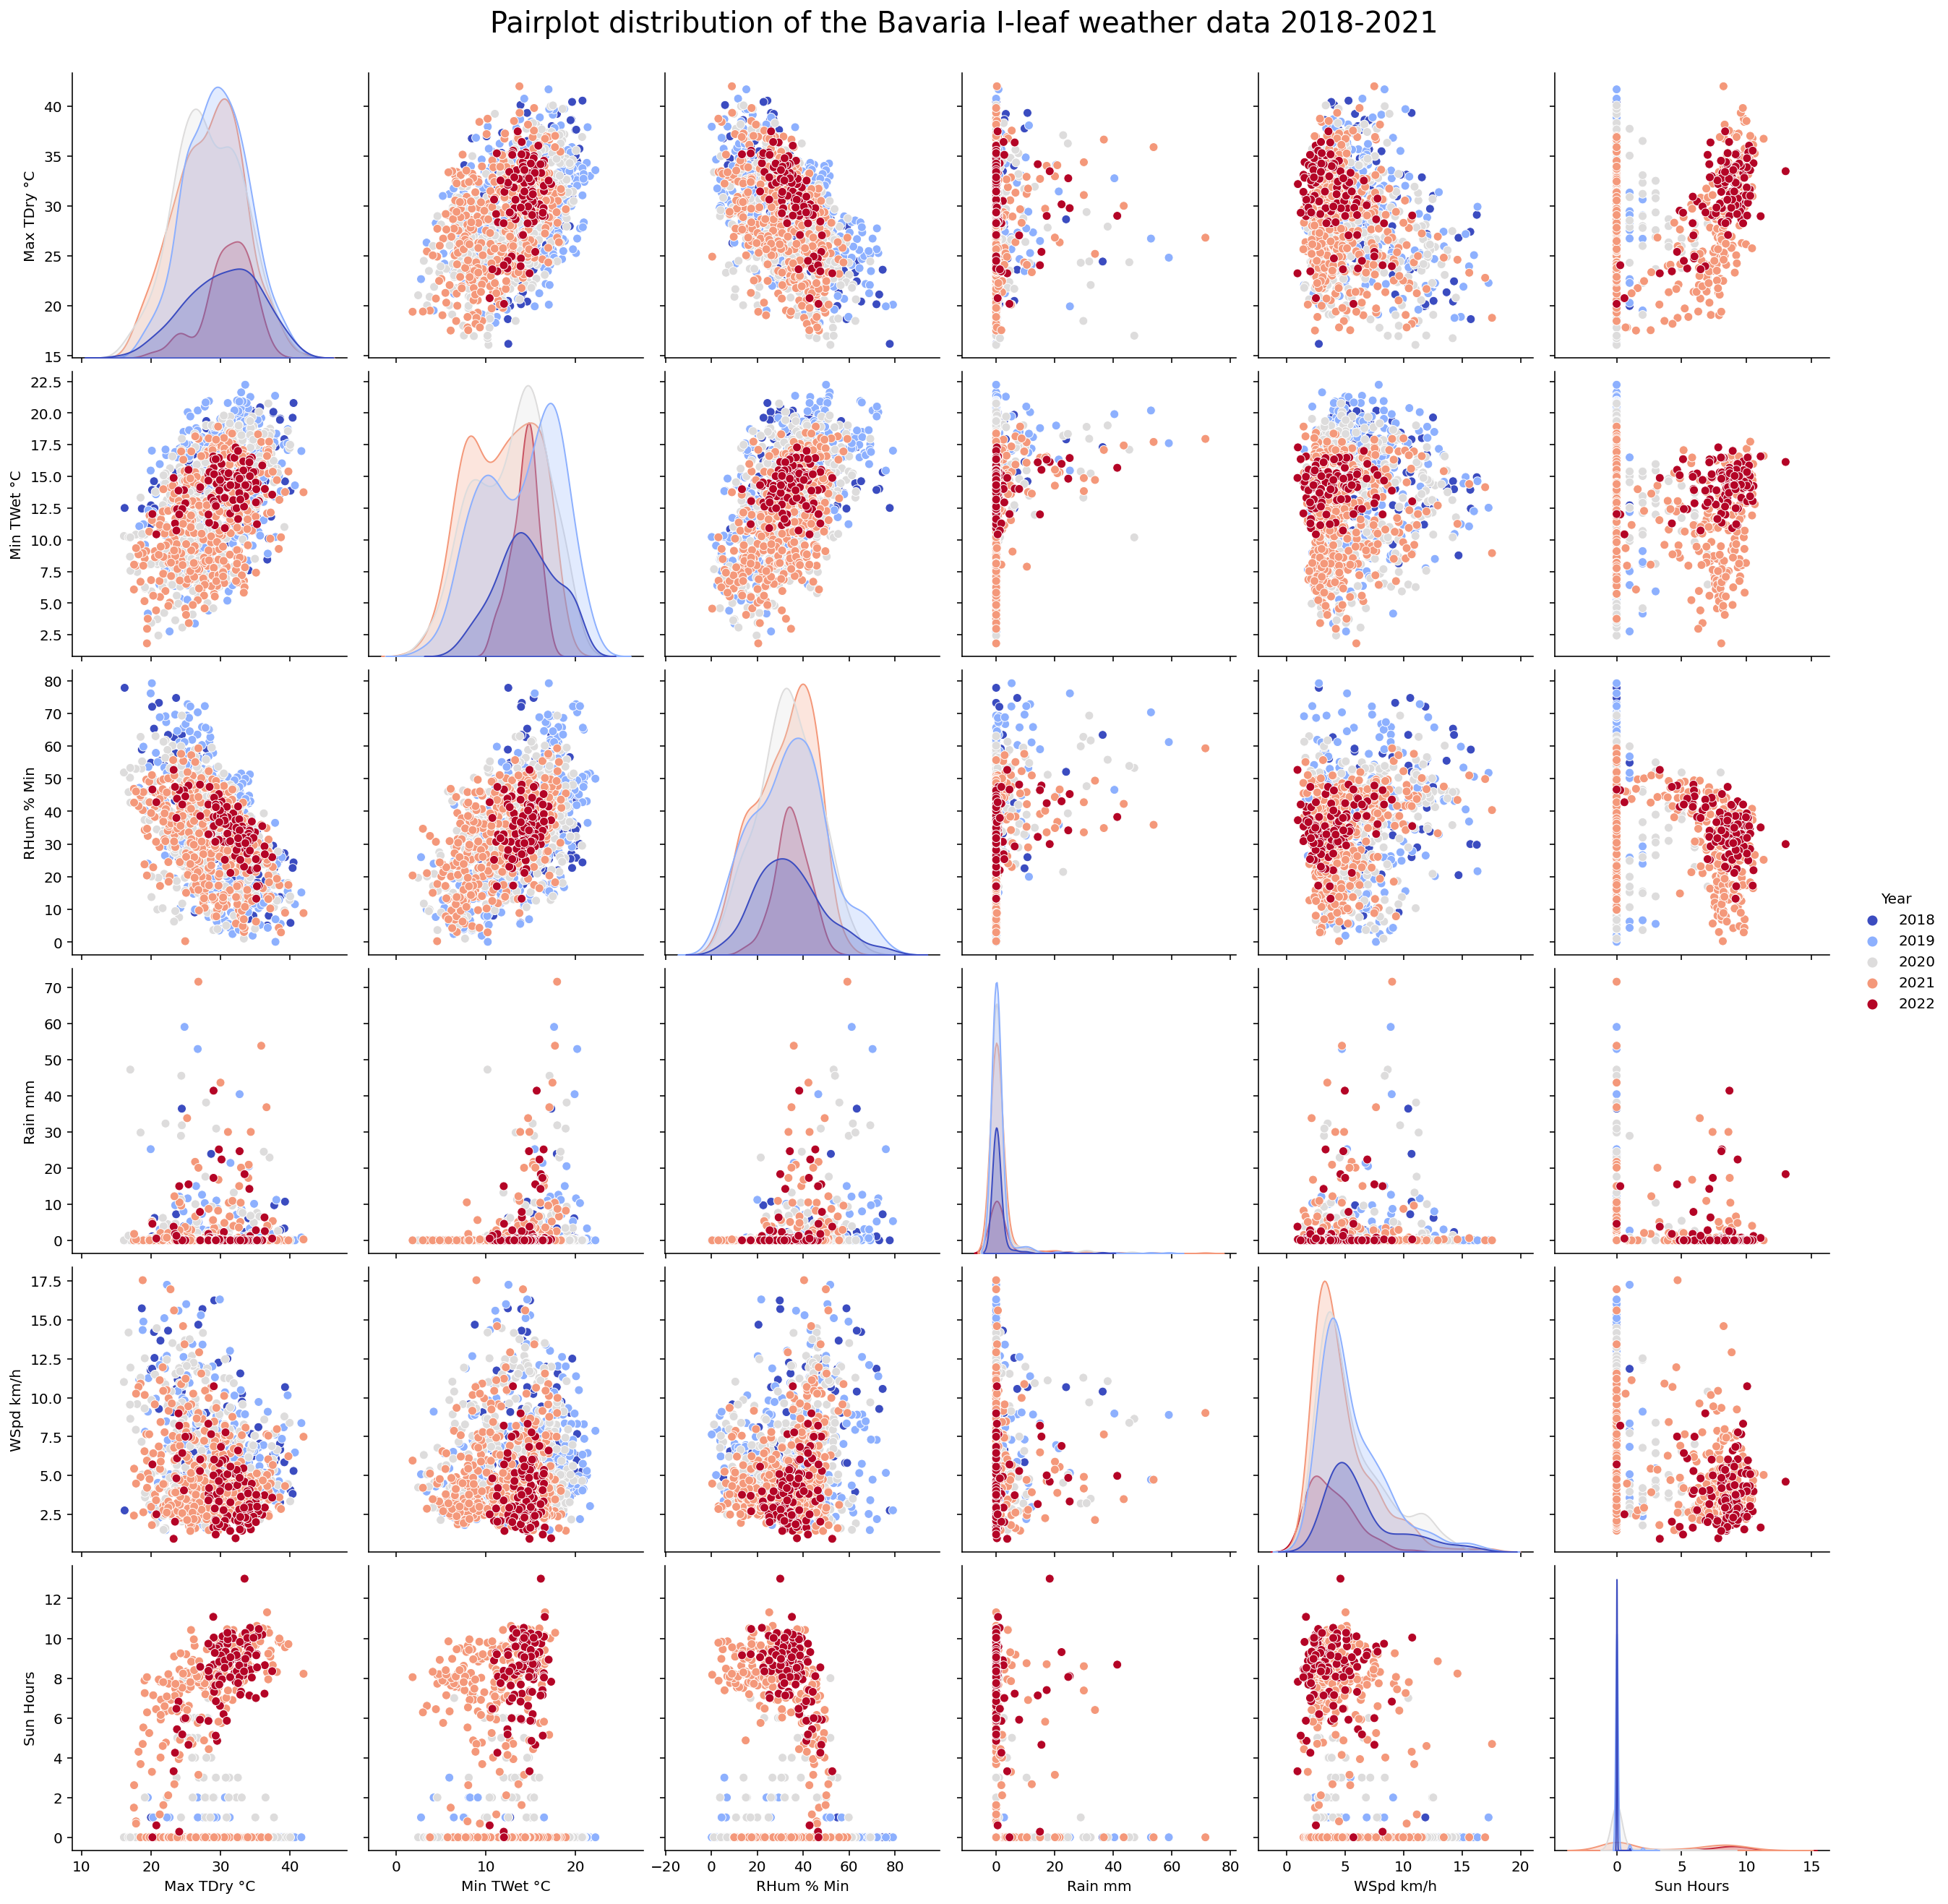

In [9]:
sns.pairplot(weather, vars=['Max TDry °C','Min TWet °C','RHum % Min','Rain mm','WSpd km/h', 'Sun Hours'],
             height=3, hue='Year', palette='coolwarm')

plt.suptitle("Pairplot distribution of the Bavaria I-leaf weather data 2018-2021", fontsize=20, y=1.02)
plt.show()

From the above diagram it can be seen that most of these feature are highly correlated with temperature, this is because weather events are usually occur at specific temperatures. Wind speed and rain however, are independent of temperature, this is because they influence atmospheric temperature and not the other way around. 

In order to properly visualise the outliers of each feature, density distributions were used. The density distributions show the shape of the data and whether it is normally distributed or not, that is where do most data points lie and whether the distribution have a tail or not.

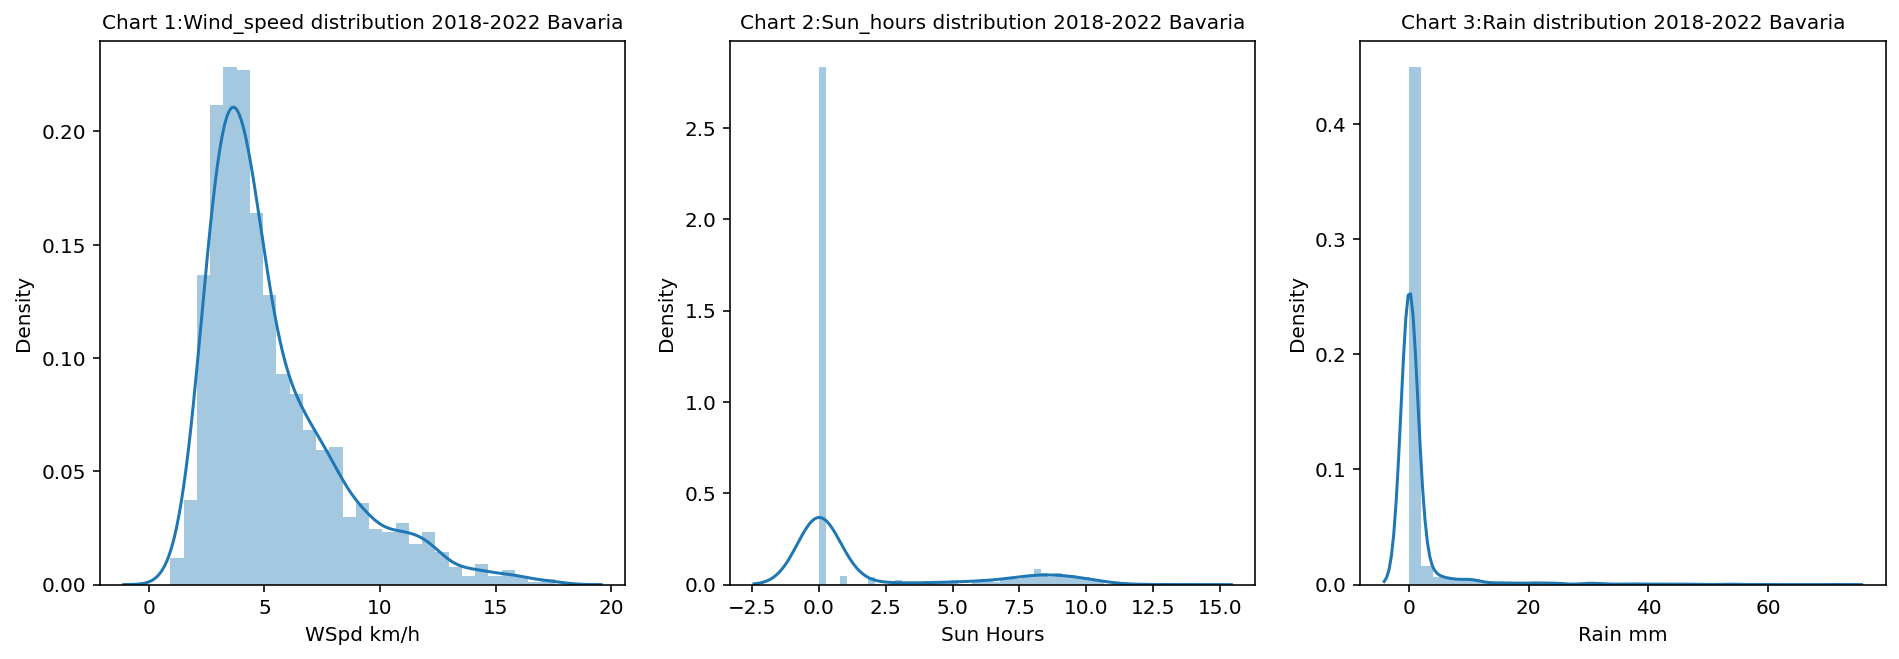

In [10]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.distplot(weather['WSpd km/h'])
plt.title('Chart 1:Wind_speed distribution 2018-2022 Bavaria', fontsize=10)
plt.subplot(1,3,2)
sns.distplot(weather['Sun Hours'])
plt.title('Chart 2:Sun_hours distribution 2018-2022 Bavaria', fontsize=10)
plt.subplot(1,3,3)
sns.distplot(weather['Rain mm'])
plt.title('Chart 3:Rain distribution 2018-2022 Bavaria', fontsize=10)
plt.show()

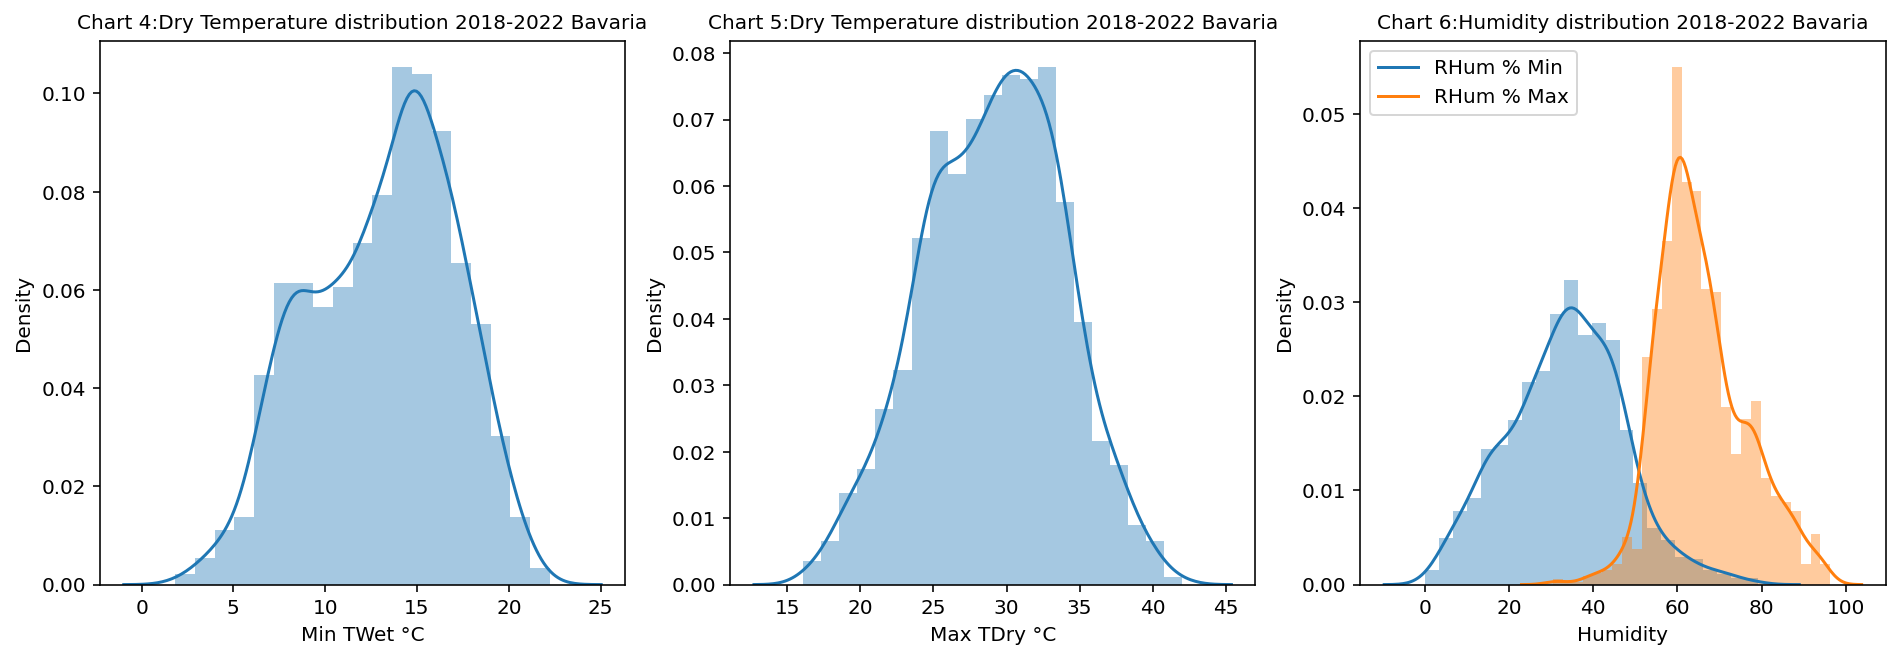

In [11]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.distplot(weather['Min TWet °C'])
plt.title('Chart 4:Dry Temperature distribution 2018-2022 Bavaria', fontsize=10)
plt.subplot(1,3,2)
sns.distplot(weather['Max TDry °C'])
plt.title('Chart 5:Dry Temperature distribution 2018-2022 Bavaria', fontsize=10)
plt.subplot(1,3,3)
sns.distplot(weather['RHum % Min'])
sns.distplot(weather['RHum % Max'])
plt.legend(labels = ['RHum % Min','RHum % Max'])
plt.title('Chart 6:Humidity distribution 2018-2022 Bavaria', fontsize=10)
plt.xlabel('Humidity')
plt.show()

### 3.3. Skewness, Kurtosis and Shapiro-Wilk test
**Skewness** is a measure of the degree of distortion in a dataset, a symmetrical dataset with a normal distribution will have a skewness value of 0.If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed) the data are moderately skewed, anything more than that means the data is highly skewed.

**Kurtosis** is a measure of the outliers in the distribution, high kurtosis represents many ouliers and a lower kurtosis represents the lack of outliers. A standard normal distribution has a kurtosis of 3, a kurtosis higher than that means a higher number of outliers and that smaller than 3 may mean the lack of outliers.

**The shapiro-Wilk test** is a test of how normal a dataset is using frequentist statistics. The null hypothesis (H0) states that the variable is normally distributed, and the alternative hypothesis (H1) states that the variable is not normally distributed. So after running the test:

- If p ≤ 0.05: then the null hypothesis can be rejected (i.e. the data is not normally distributed).
- If p > 0.05: then the null hypothesis cannot be rejected (i.e. the variable may be normally distributed).


In [12]:
columns = ['Max TDry °C','Min TWet °C','RHum % Min','RHum % Max','Rain mm','WSpd km/h', 'Sun Hours']
skew = []
for col in columns:
    sk =weather[col].skew()
    skew.append(sk)
    
kurt = []
for col in columns:
    kt =weather[col].kurt()
    kurt.append(kt)

stats = []
for col in columns:
    st = round(shapiro(weather[col]).statistic,3)
    stats.append(st)

pval = []
for col in columns:
    p = shapiro(weather[col]).pvalue
    pval.append(p)

gauss = []
for i in pval:    
    if p > 0.05:
        a = 'Probably Gaussian'
    else:
        a = 'Probably not Gaussian'
    gauss.append(a)

In [13]:
data = {'Feature ':['Max TDry °C','Min TWet °C','RHum % Min','RHum % Max','Rain mm','WSpd km/h', 'Sun Hours'],
        'Skewness':skew,
        'Kurtosis':kurt,
        'Shapiro stat':stats,
        'Shapiro':pval,
        'Gaussian or not':gauss}

data_testing_df = pd.DataFrame(data)
data_testing_df

Feature   Skewness   Kurtosis  Shapiro stat       Shapiro  \
0  Max TDry °C -0.121604  -0.401297         0.995  3.497281e-04   
1  Min TWet °C -0.262467  -0.680787         0.982  9.069813e-12   
2   RHum % Min  0.095547  -0.037781         0.994  2.682789e-05   
3   RHum % Max  0.501366   0.197211         0.971  6.907868e-16   
4      Rain mm  6.266568  46.993401         0.263  0.000000e+00   
5    WSpd km/h  1.412366   1.919384         0.874  1.192402e-31   
6    Sun Hours  1.447017   0.345985         0.582  0.000000e+00   

         Gaussian or not  
0  Probably not Gaussian  
1  Probably not Gaussian  
2  Probably not Gaussian  
3  Probably not Gaussian  
4  Probably not Gaussian  
5  Probably not Gaussian  
6  Probably not Gaussian

From the table above it can be seen that the wind speed, wind degrees, sun hours and rain are the most skewed; all these variables are skewed to the right. The shapiro-Wilk test tells us that all the features are not normally distributed. Rain has a kurtosis of 47 which is the highest of all data features and indicates that there are potentially a lot of outliers in rainfall, this leads us to investigate outliers further using the isolation forest model. 

### 4. Outlier analysis of the features using isolation forest

#### Rainfall

In [14]:
isolation_forest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)

isolation_forest.fit(weather['Rain mm'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, random_state=42)

In [15]:
rain = np.linspace(
    weather["Rain mm"].min(),
    weather["Rain mm"].max(),
    len(weather),
).reshape(-1, 1)

anomaly_score_rain = isolation_forest.decision_function(rain)

outlier_rain = isolation_forest.predict(rain)

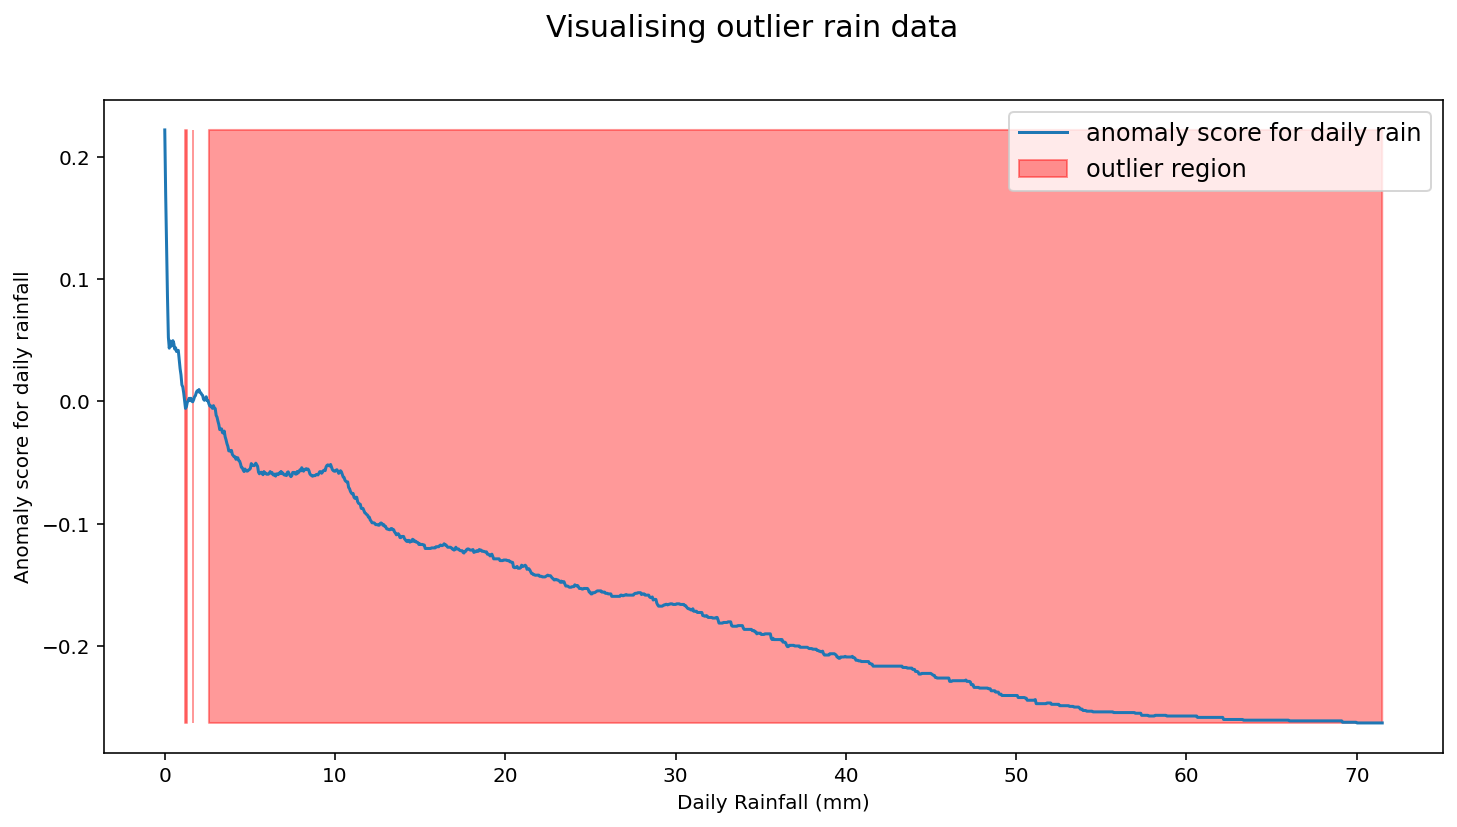

In [16]:
# Plotting the outlier region
plt.figure(figsize=(12,6))
plt.plot(rain , anomaly_score_rain, label="anomaly score for daily rain")
plt.fill_between(
    rain.T[0],
    np.min(anomaly_score_rain),
    np.max(anomaly_score_rain),
    where=outlier_rain == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=12)
plt.ylabel("Anomaly score for daily rainfall", fontsize=10)
plt.xlabel("Daily Rainfall (mm)", fontsize=10)

plt.suptitle("Visualising outlier rain data", fontsize=15)
plt.show()

The chart above seperates the abnormal data points (outliers) from the normal data points (inliers). The outliers lie on "the red zone" which is the area shaded in red, the rain outliers start from 2mm. These results will be explored further in the analysis below.

In [17]:
weather['Rain scores']= isolation_forest.decision_function(weather[['Rain mm']])
weather['Rain anomaly']= isolation_forest.predict(weather[['Rain mm']])

In [18]:
weather.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
0        12.72        20.00        54.9        83.4      0.0  11.858235   
1        12.51        16.20        77.8        94.5      0.0   2.756666   
2        14.46        23.36        62.7        95.7      0.3   3.948333   
3         8.95        25.22        20.6        75.0      0.0   5.243333   
4         8.71        25.44        33.9        77.4      0.0   5.001666   

   Sun Hours  Day  Month  Year  Rain scores  Rain anomaly  
0        1.0    8      8  2018     0.222364             1  
1        0.0    9      8  2018     0.222364             1  
2        0.0   10      8  2018     0.048929             1  
3        0.0   11      8  2018     0.222364             1  
4        0.0   12      8  2018     0.222364             1

A 'Rain anomaly' value of -1 indicates that the rain data point is an anomaly, while a value of 1 represents a normal data point. 

The following DataFrame is an anomaly data frame which contains only the data points that the isolation forest flagged as anomalies.

In [19]:
rain_anomaly=weather.loc[weather['Rain anomaly']==-1]
rain_anomaly_index=list(rain_anomaly.index)

In [20]:
rain_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
70         15.33        23.63        74.7        93.3      7.2  10.567916   
85         16.97        24.77        58.3        94.1      3.9   5.809583   
91         12.48        20.51        49.5        93.0      6.2  12.558750   
112        14.61        39.34        26.0        87.5     10.7  10.682916   
116        16.14        37.78        22.6        89.1      9.7   5.855416   

     Sun Hours  Day  Month  Year  Rain scores  Rain anomaly  
70         0.0   17     10  2018    -0.058122            -1  
85         0.0    1     11  2018    -0.040495            -1  
91         0.0    7     11  2018    -0.058313            -1  
112        0.0   28     11  2018    -0.065894            -1  
116        0.0    2     12  2018    -0.052036            -1

The Rain column has 132 anomalies, these represent 9.76% of the data in line with the set contamination factor of 0.1 which isolates about 10% of the data. The analysis below was to test the anomaly dataframe. It can be seen below that the mean of the anomaly dataframe is higher than that of the initial weather data, the minimum is however, still low at 1.2. This could mean that the anomaly detection model doesn't only consider extremes. 

In [21]:
print(weather['Rain mm'].describe())
print('\nNon zero rain data points in the weather DataFrame:' , (weather['Rain mm']>0).sum())
print('Percentage of non zero rain data points in the weather DataFrame:' , round((251/1352)*100,2))

count    1352.000000
mean        1.430725
std         5.877376
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        71.500000
Name: Rain mm, dtype: float64

Non zero rain data points in the weather DataFrame: 251
Percentage of non zero rain data points in the weather DataFrame: 18.57


The original rain data is mostly zeros and only has 251 ~ 18.57% non-zero values.

In [22]:
print(rain_anomaly['Rain mm'].describe())
print('\nNon zero rain data points in the anomaly DataFrame:' , (rain_anomaly['Rain mm']>0).sum())
print('Percentage of rain data points flagged as anomalies from the non zero data points:' , round((132/251)*100,2))

count    132.000000
mean      13.830379
std       13.545020
min        1.200000
25%        4.552500
50%        8.700000
75%       18.740000
max       71.500000
Name: Rain mm, dtype: float64

Non zero rain data points in the anomaly DataFrame: 132
Percentage of rain data points flagged as anomalies from the non zero data points: 52.59


We can see that the anomaly data points make up 52.59% of the data points that are not zero. This is a large portion of the non-zero data, and the anomaly data has no zeros. This implies that the algorithm took all the zero values as normal. The outcome makes sense as those are the days where there is no rain, and that is a fairly a normal situation, unless there is a drought in the area.

In the graph below we can see that based on the seasonal occurance of rain, there is a fairly large proportion of days where it does not rain, which is represented as 'zeros' in the data.

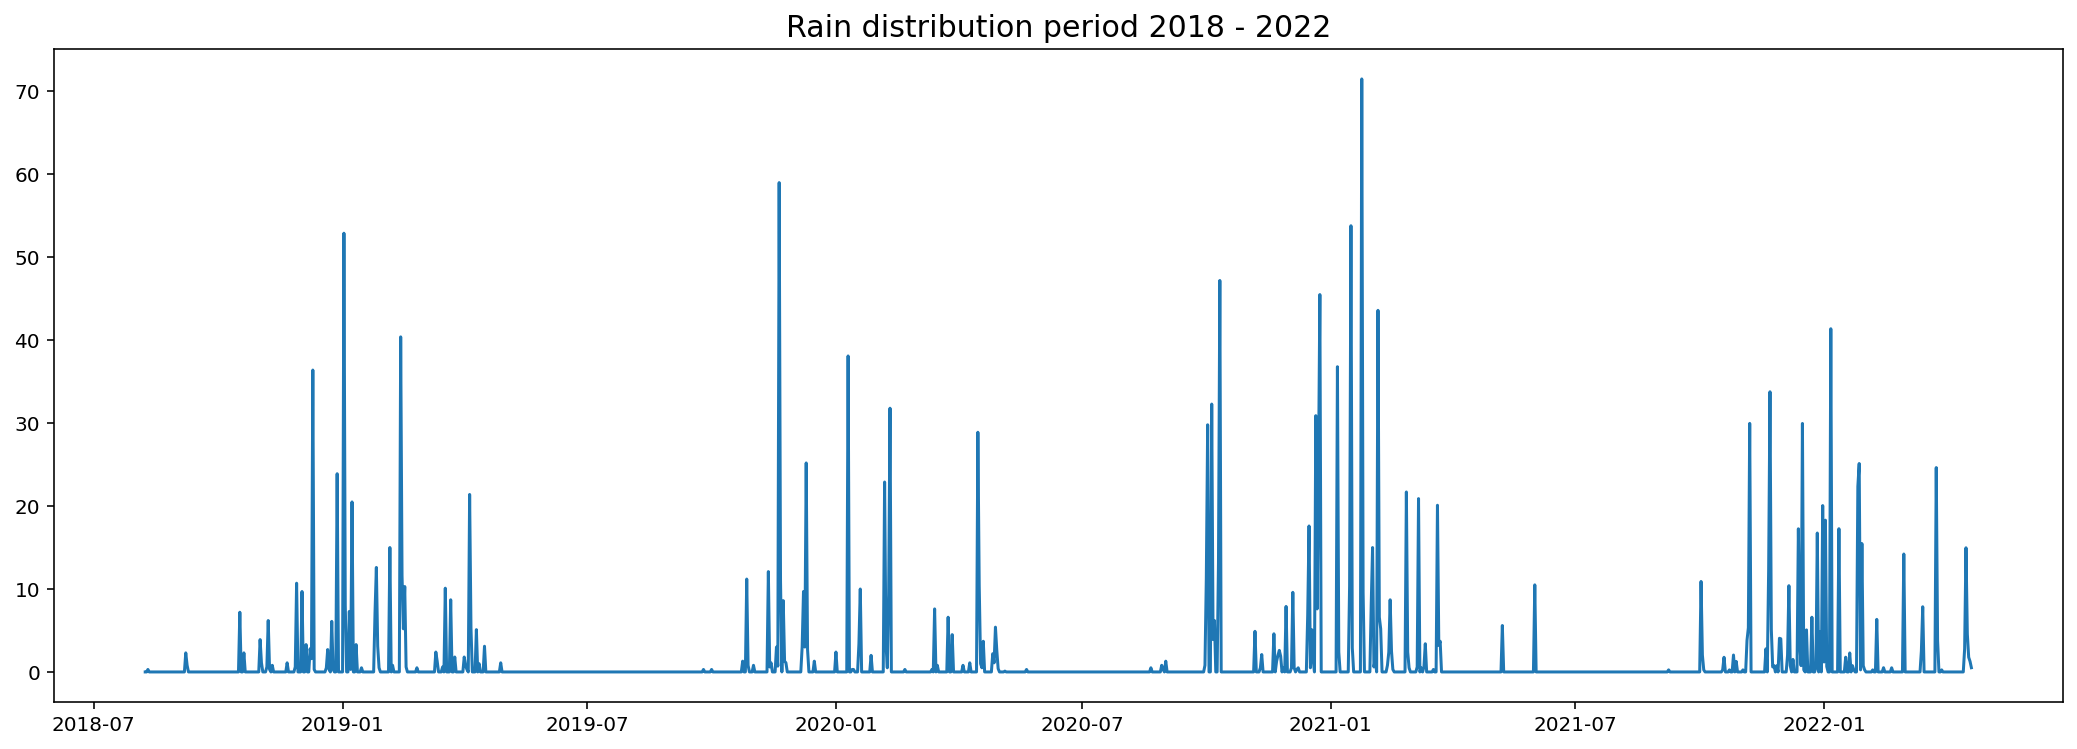

In [23]:
plt.figure(figsize=(18,6))
plt.plot(original_weather['Date'], original_weather['Rain mm'])
plt.title('Rain distribution period 2018 - 2022', fontsize=15)
plt.show()

Text(0.5, 1.0, 'Rain anomaly distribution')

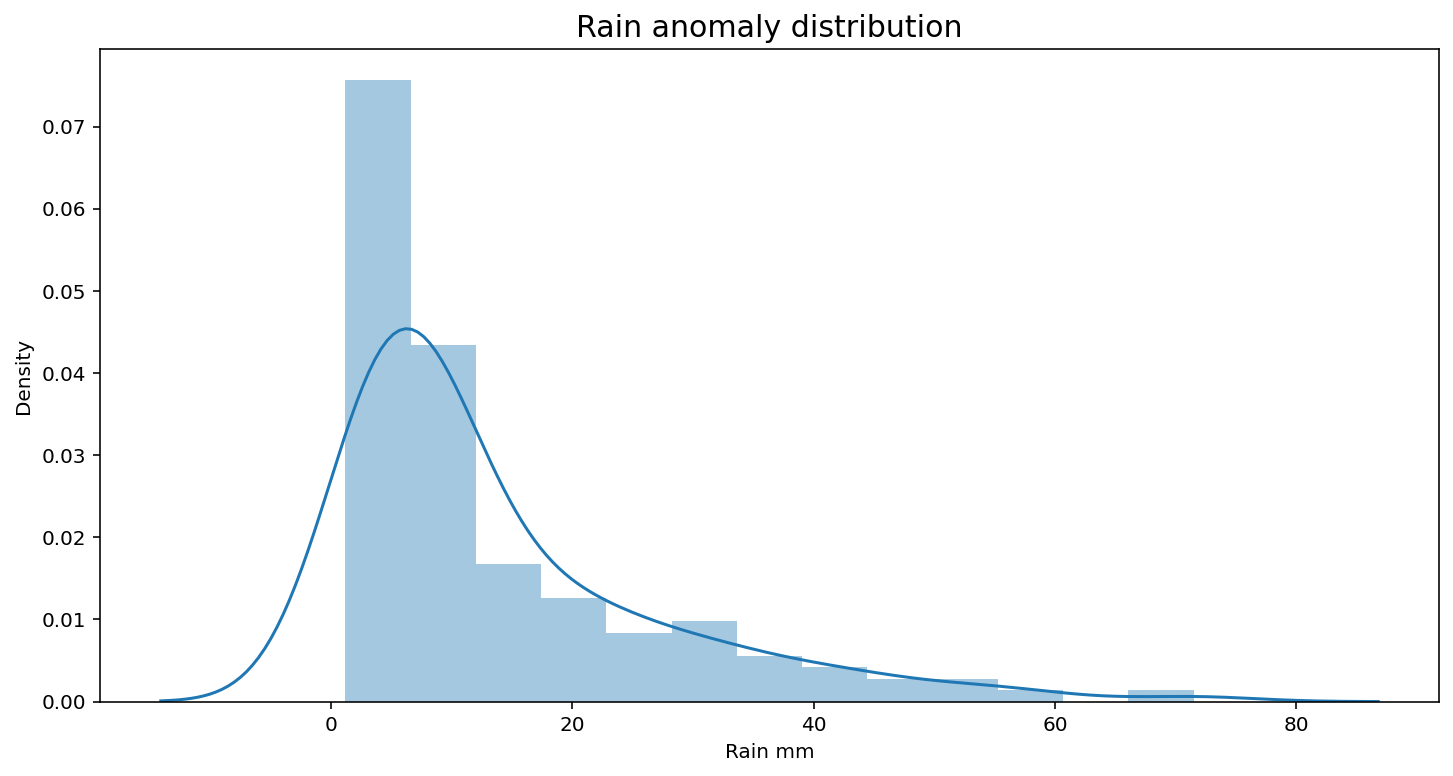

In [24]:
plt.figure(figsize=(12,6))
sns.distplot(rain_anomaly['Rain mm'])
plt.title('Rain anomaly distribution', fontsize=15)

Isolating the days where there is no rain will help to properly visualize the outliers of the days were it actually rains. Focusing only on the days where there is rain will help us see which of those days will be flagged as anomalies and whether the anomaly detection results improve.

#### Rainfall - Rainfall data excluding zero rain days

In [25]:
columns = ['Rain mm']
weather_copy = weather.copy()
no_zero_rain_weather = weather_copy.replace(0, pd.np.nan).dropna(axis=0, how='any', subset=columns).fillna(0)

In [26]:
no_zero_rain_weather.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
2         14.46        23.36        62.7        95.7      0.3   3.948333   
30        16.05        33.51        33.2        77.2      2.3   3.512916   
31        15.55        26.05        56.1        79.4      0.8   3.629166   
70        15.33        23.63        74.7        93.3      7.2  10.567916   
73        13.99        22.47        63.4        87.5      2.3  14.310416   

    Sun Hours  Day  Month  Year  Rain scores  Rain anomaly  
2         0.0   10      8  2018     0.048929             1  
30        0.0    7      9  2018     0.002610             1  
31        0.0    8      9  2018     0.042862             1  
70        0.0   17     10  2018    -0.058122            -1  
73        0.0   20     10  2018     0.002610             1

In [27]:
print("Skewness: %f" % no_zero_rain_weather['Rain mm'].skew())
print("Kurtosis: %f" % no_zero_rain_weather["Rain mm"].kurt())
print("\nThe skewness and the curtosis of the data decreases when the zero data points are removed, \nthis means that the zeros were skewing the data")
print("\nno_zero_rain_weather DataFrame shape: ",no_zero_rain_weather.shape)

Skewness: 2.502483
Kurtosis: 6.930681

The skewness and the curtosis of the data decreases when the zero data points are removed, 
this means that the zeros were skewing the data

no_zero_rain_weather DataFrame shape:  (251, 12)


In [28]:
isolation_forest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)

isolation_forest.fit(no_zero_rain_weather['Rain mm'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, random_state=42)

In [29]:
rain2 = np.linspace(
    no_zero_rain_weather["Rain mm"].min(),
    no_zero_rain_weather["Rain mm"].max(),
    len(no_zero_rain_weather),
).reshape(-1, 1)

anomaly_score_rain2 = isolation_forest.decision_function(rain2)

outlier_rain2 = isolation_forest.predict(rain2)

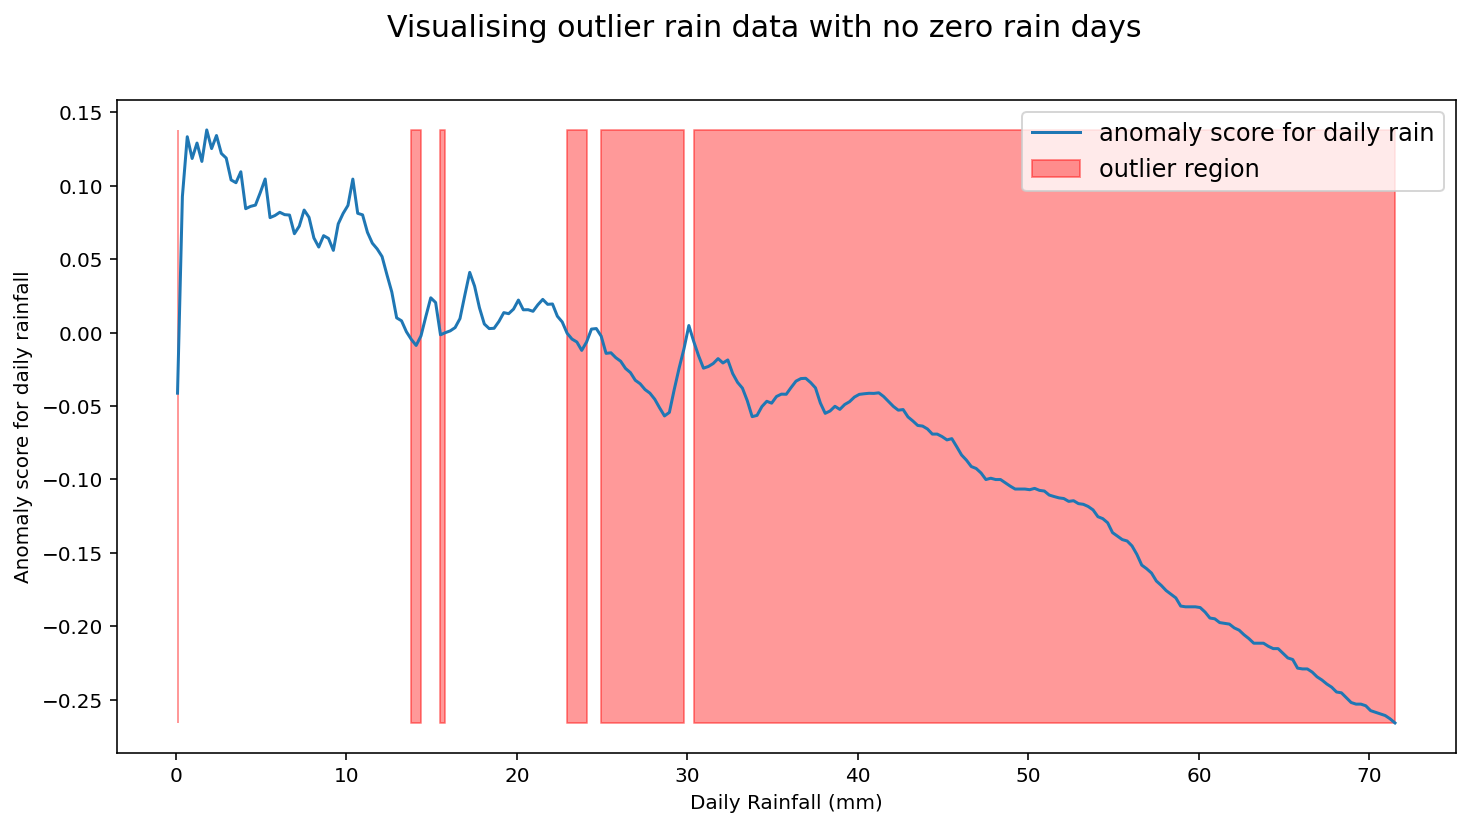

In [30]:
# Plotting the outlier region
plt.figure(figsize=(12, 6))
plt.plot(rain2 , anomaly_score_rain2, label="anomaly score for daily rain")
plt.fill_between(
    rain2.T[0],
    np.min(anomaly_score_rain2),
    np.max(anomaly_score_rain2),
    where=outlier_rain2 == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=12)
plt.ylabel("Anomaly score for daily rainfall", fontsize=10)
plt.xlabel("Daily Rainfall (mm)", fontsize=10)

plt.suptitle("Visualising outlier rain data with no zero rain days", fontsize=15)
plt.show()

In [31]:
no_zero_rain_weather['Rain scores no_Zero']= isolation_forest.decision_function(no_zero_rain_weather[['Rain mm']])
no_zero_rain_weather['Rain anomaly no_Zero']= isolation_forest.predict(no_zero_rain_weather[['Rain mm']])

In [32]:
no_zero_rain_weather.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
2         14.46        23.36        62.7        95.7      0.3   3.948333   
30        16.05        33.51        33.2        77.2      2.3   3.512916   
31        15.55        26.05        56.1        79.4      0.8   3.629166   
70        15.33        23.63        74.7        93.3      7.2  10.567916   
73        13.99        22.47        63.4        87.5      2.3  14.310416   

    Sun Hours  Day  Month  Year  Rain scores  Rain anomaly  \
2         0.0   10      8  2018     0.048929             1   
30        0.0    7      9  2018     0.002610             1   
31        0.0    8      9  2018     0.042862             1   
70        0.0   17     10  2018    -0.058122            -1   
73        0.0   20     10  2018     0.002610             1   

    Rain scores no_Zero  Rain anomaly no_Zero  
2              0.153685                     1  
30             0.134400                     1  
31             0.160884                     1  
70             0.071753                     1  
73             0.134400                     1

In [33]:
no_zero_rain_anomaly=no_zero_rain_weather.loc[no_zero_rain_weather['Rain anomaly no_Zero']==-1]
no_zero_rain_anomaly_index=list(no_zero_rain_weather.index)

In [34]:
no_zero_rain_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
124        17.31        24.45        63.4        92.6     36.4  10.395833   
142        17.92        28.68        52.1        85.6     23.9  10.680416   
147        20.20        26.75        70.3        93.5     52.9   4.732916   
189        19.91        32.79        46.6        90.2     40.4   8.985000   
469        17.62        24.84        61.2        80.8     59.0   8.897500   

     Sun Hours  Day  Month  Year  Rain scores  Rain anomaly  \
124        0.0   10     12  2018    -0.197141            -1   
142        0.0   28     12  2018    -0.152189            -1   
147        0.0    2      1  2019    -0.249210            -1   
189        0.0   13      2  2019    -0.208776            -1   
469        0.0   20     11  2019    -0.257656            -1   

     Rain scores no_Zero  Rain anomaly no_Zero  
124            -0.034169                    -1  
142            -0.011751                    -1  
147            -0.116080                    -1  
189            -0.041685                    -1  
469            -0.186334                    -1

In [35]:
no_zero_rain_anomaly['Rain mm'].describe()

count    25.000000
mean     35.239600
std      15.264874
min       0.100000
25%      25.200000
50%      33.780000
75%      43.600000
max      71.500000
Name: Rain mm, dtype: float64

With the no rain days data (zero rain) isolated, there are only 25 anomalies that are flagged instead of the initial 132, this is because the model is now taking 10% of 251 not 1352. The data has a higher mean, percentile values. The initial data had a 75% of 0mm in this data it is 43mm, this is a more realistic view than the initial anomaly detection that flagged the anomalous rain from about 2mm. In this scenario higher rainfall is flagged instead.

Text(0.5, 1.0, 'Chart 9:No zero rain days data; rain anomaly distribution')

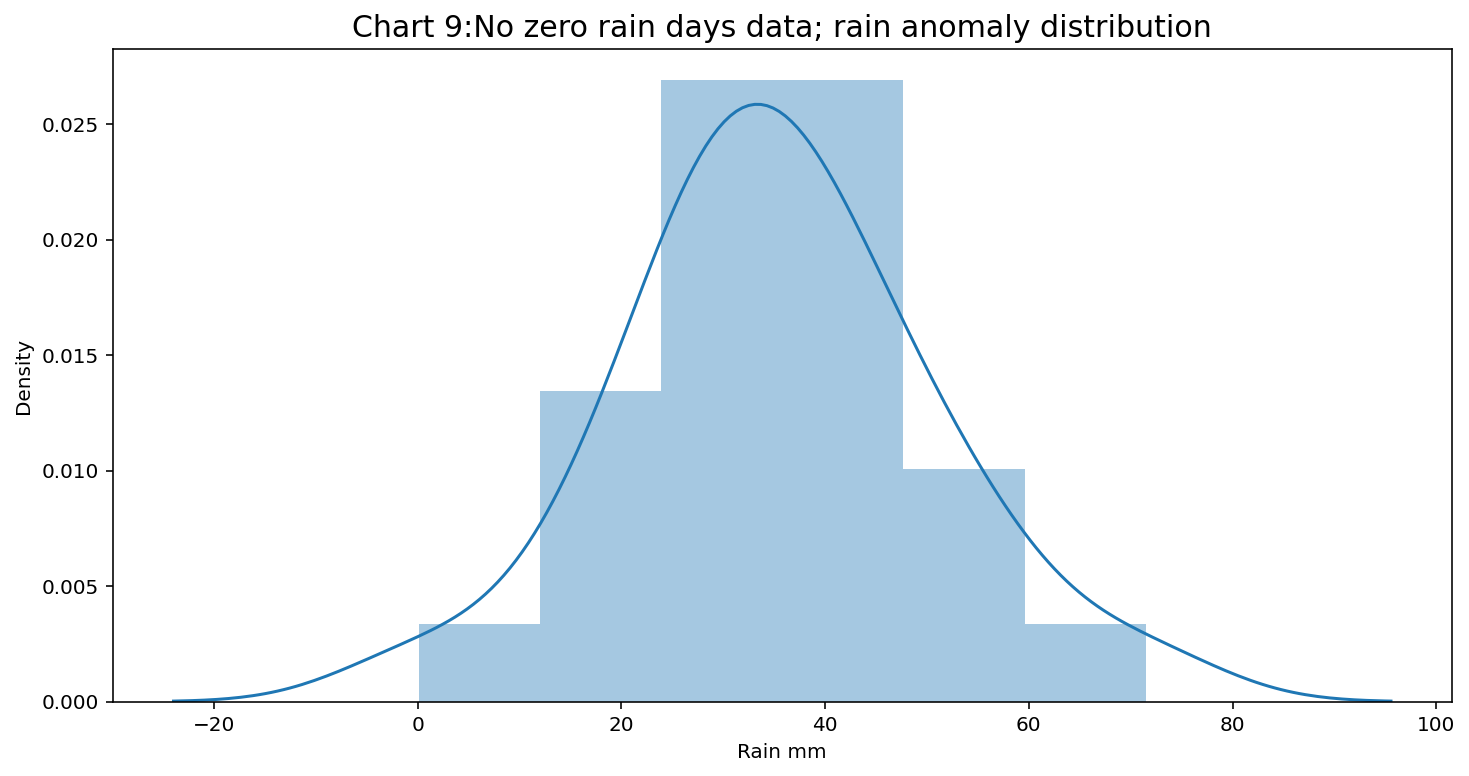

In [36]:
plt.figure(figsize=(12,6))
sns.distplot(no_zero_rain_anomaly['Rain mm'])
plt.title('Chart 9:No zero rain days data; rain anomaly distribution', fontsize=15)

In [37]:
print("Skewness: %f" % no_zero_rain_anomaly['Rain mm'].skew())
print("Kurtosis: %f" % no_zero_rain_anomaly['Rain mm'].kurt())

Skewness: 0.132728
Kurtosis: 0.762510


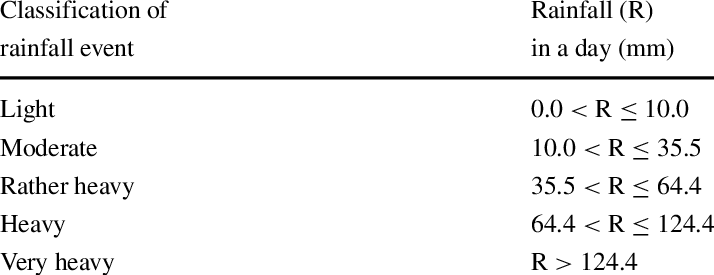

In [38]:
display.Image(("Rainfall classification.png"))


Most anomalies are around 30-40 mm. 60mm is very abnormal but doesn't occur as frequently, this is a signal of very heavy rain and could be an insurance event aa heavy rain is usually associated with hail.

#### Maximum temperature

In [39]:
isolation_forest = IsolationForest( n_estimators=500, n_jobs=-1, random_state=42, contamination=0.1)

isolation_forest.fit(weather['Max TDry °C'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, n_estimators=500, n_jobs=-1, random_state=42)

In [40]:
max_temp = np.linspace(
    weather["Max TDry °C"].min(),
    weather["Max TDry °C"].max(),
    len(weather),
).reshape(-1, 1)


anomaly_score_maxtemp = isolation_forest.decision_function(max_temp)

outlier_maxtemp = isolation_forest.predict(max_temp)

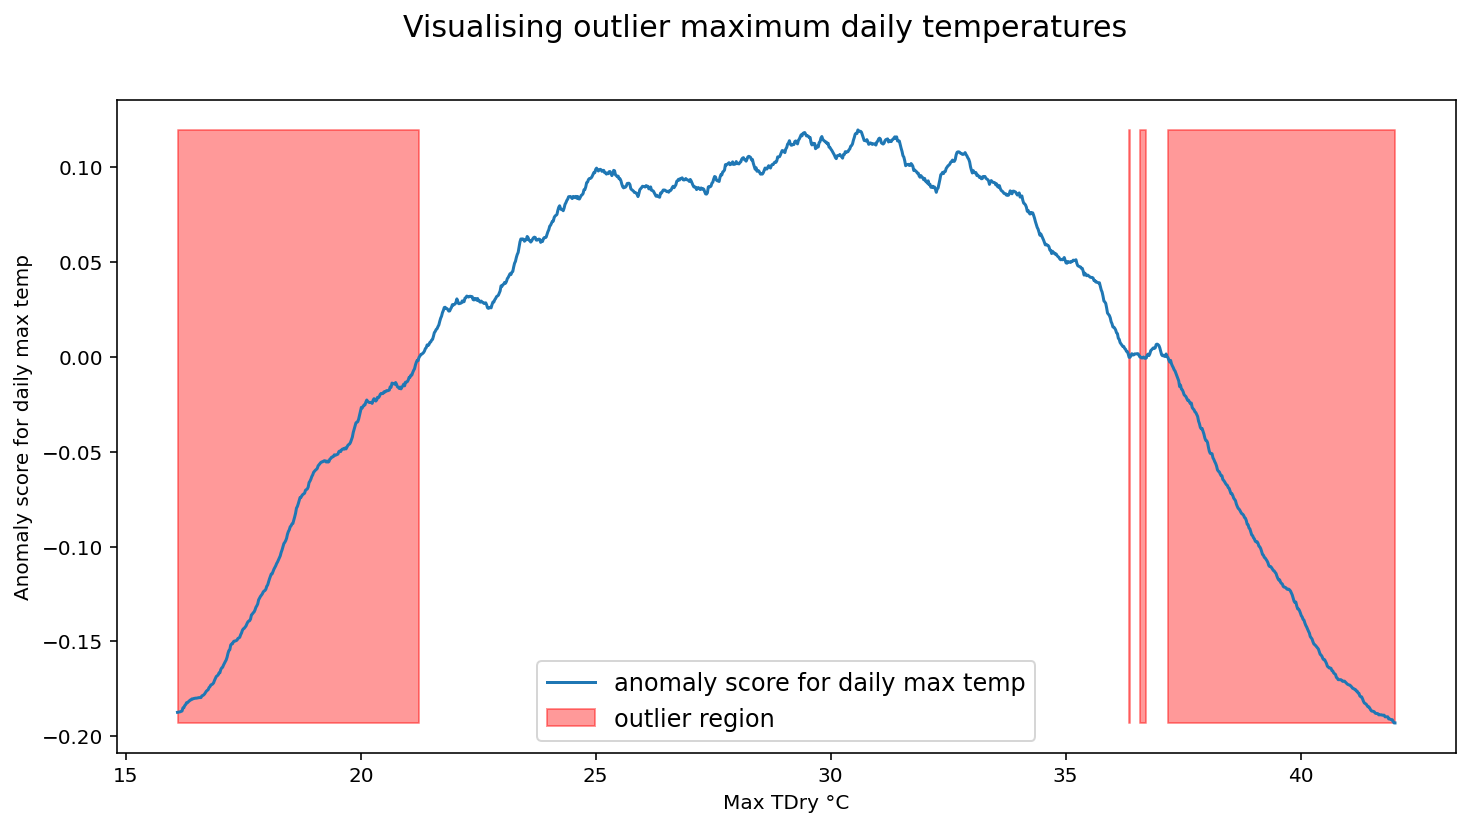

In [41]:
plt.figure(figsize=(12,6))
plt.plot(max_temp, anomaly_score_maxtemp, label='anomaly score for daily max temp')
plt.fill_between(
    max_temp.T[0],
    np.min(anomaly_score_maxtemp),
    np.max(anomaly_score_maxtemp),
    where= outlier_maxtemp ==-1,
    color='r',
    alpha=0.4,
    label='outlier region')

plt.legend(fontsize=12)
plt.ylabel('Anomaly score for daily max temp', fontsize=10)
plt.xlabel("Max TDry °C", fontsize=10)

plt.suptitle("Visualising outlier maximum daily temperatures", fontsize=15)
plt.show()

We can see that the outliers are on the area where the max temperature is less or equal to about 22.0°C and on the area where the temperature is greater than or equal to about 36.0°C. The area less than 22.0°C for the max temp correlates with the fact that Hoedspruit is a hot area and the maximum temperature is usally hotter than 22.0°C. The area above 37.0°C is the hottest weather and above 40.0°C is the extreme and is also a rare occurance. Temperatures above 40 are an area of interest as they pose a potential veld fire risk. Based on research temperatures above 40 are an area of interest as they pose a very high potential veld fire risk. 

In [42]:
weather['Max Temp scores']= isolation_forest.decision_function(weather[["Max TDry °C"]])
weather['Max Temp anomaly']= isolation_forest.predict(weather[["Max TDry °C"]])

In [43]:
max_temp_anomaly=weather.loc[weather['Max Temp anomaly']==-1]
max_temp_anomaly_index=list(max_temp_anomaly.index)
max_temp_anomaly.drop(['Rain scores','Rain anomaly'],axis = 1, inplace = True)

In [44]:
max_temp_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
0         12.72        20.00        54.9        83.4      0.0  11.858235   
1         12.51        16.20        77.8        94.5      0.0   2.756666   
10        12.46        18.68        58.9        76.5      0.0  15.745000   
16        14.02        21.15        73.2        89.0      0.0   9.280833   
41        13.87        40.13         5.9        47.9      0.0   4.071250   

    Sun Hours  Day  Month  Year  Max Temp scores  Max Temp anomaly  
0         1.0    8      8  2018        -0.027766                -1  
1         0.0    9      8  2018        -0.186649                -1  
10        0.0   18      8  2018        -0.075878                -1  
16        0.0   24      8  2018        -0.005469                -1  
41        0.0   18      9  2018        -0.142367                -1

In [45]:
max_temp_anomaly['Max TDry °C'].describe()

count    136.000000
mean      28.078382
std        9.561400
min       16.100000
25%       19.515000
50%       20.980000
75%       37.962500
max       42.010000
Name: Max TDry °C, dtype: float64

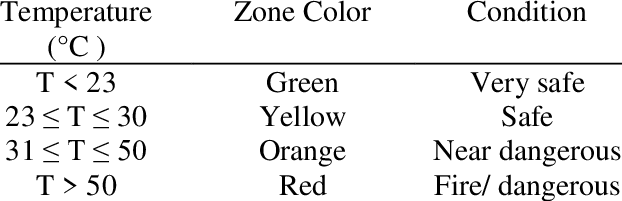

In [46]:
display.Image("temperature classification.png")

#### Minimun temperature

In [47]:
isolation_forest = IsolationForest( n_estimators=500, n_jobs=-1, random_state=42, contamination=0.1)

isolation_forest.fit(weather['Min TWet °C'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, n_estimators=500, n_jobs=-1, random_state=42)

In [48]:
min_temp = np.linspace(
    weather['Min TWet °C'].min(),
    weather['Min TWet °C'].max(),
    len(weather),
).reshape(-1, 1)


anomaly_score_mintemp = isolation_forest.decision_function(min_temp)

outlier_mintemp = isolation_forest.predict(min_temp)

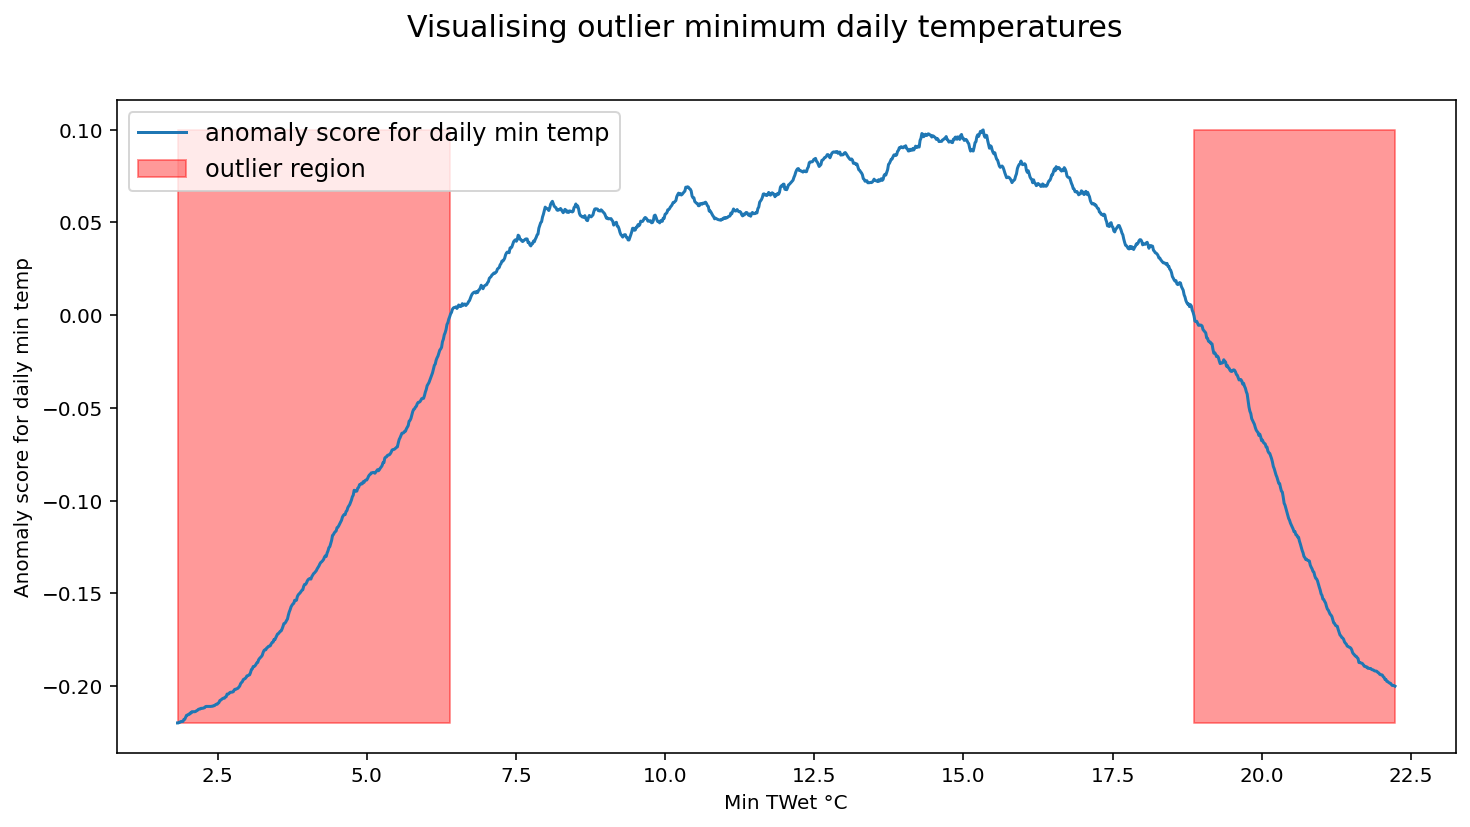

In [49]:
plt.figure(figsize=(12,6))
plt.plot(min_temp, anomaly_score_mintemp, label='anomaly score for daily min temp')
plt.fill_between(
    min_temp.T[0],
    np.min(anomaly_score_mintemp),
    np.max(anomaly_score_mintemp),
    where= outlier_mintemp ==-1,
    color='r',
    alpha=0.4,
    label='outlier region')

plt.legend(fontsize=12)
plt.ylabel('Anomaly score for daily min temp', fontsize=10)
plt.xlabel('Min TWet °C', fontsize=10)

plt.suptitle("Visualising outlier minimum daily temperatures", fontsize=15)
plt.show()

The minimum daily wet temperatures at Bavaria only go as low as 1.8°C, the dataset has no temperatures below zero. Based on the graph above it can be observed that temperatures below 6°C have been flagged as anomalies and so have the ones above 18°C. according to literature Hoedspruit is a warm area and rarely has extremely cold weather even in winter, but it is rare for the minimum temperature to be above 18°C. 

In [50]:
weather['Min Temp scores']= isolation_forest.decision_function(weather[['Min TWet °C']])
weather['Min Temp anomaly']= isolation_forest.predict(weather[['Min TWet °C']])

In [51]:
min_temp_anomaly=weather.loc[weather['Min Temp anomaly']==-1]
min_temp_anomaly_index=list(min_temp_anomaly.index)
min_temp_anomaly.drop(['Rain scores','Rain anomaly','Max Temp scores','Max Temp anomaly'],axis = 1, inplace = True)

In [52]:
min_temp_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
111        20.00        37.63        29.5        61.8      0.6   6.317916   
117        19.01        31.66        47.7        91.5      0.0   4.914583   
120        19.49        34.36        35.0        82.5      0.0   4.585833   
121        20.45        35.75        30.1        81.4      0.0   4.078333   
122        19.56        38.65        27.1        86.8      2.8   6.663750   

     Sun Hours  Day  Month  Year  Min Temp scores  Min Temp anomaly  
111        0.0   27     11  2018        -0.067449                -1  
117        0.0    3     12  2018        -0.006875                -1  
120        0.0    6     12  2018        -0.029888                -1  
121        0.0    7     12  2018        -0.109740                -1  
122        0.0    8     12  2018        -0.030309                -1

In [53]:
min_temp_anomaly['Min TWet °C'].describe()

count    136.000000
mean      13.224338
std        7.445786
min        1.830000
25%        5.575000
50%       19.010000
75%       19.747500
max       22.230000
Name: Min TWet °C, dtype: float64

#### Relative humidity
#### Minimum relative humidity

In [54]:
isolation_forest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)

isolation_forest.fit(weather['RHum % Min'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, random_state=42)

In [55]:
min_humidity = np.linspace(
    weather["RHum % Min"].min(),
    weather["RHum % Min"].max(),
    len(weather),
).reshape(-1, 1)

anomaly_score_minhumidity = isolation_forest.decision_function(min_humidity)

outlier_minhumidity = isolation_forest.predict(min_humidity)

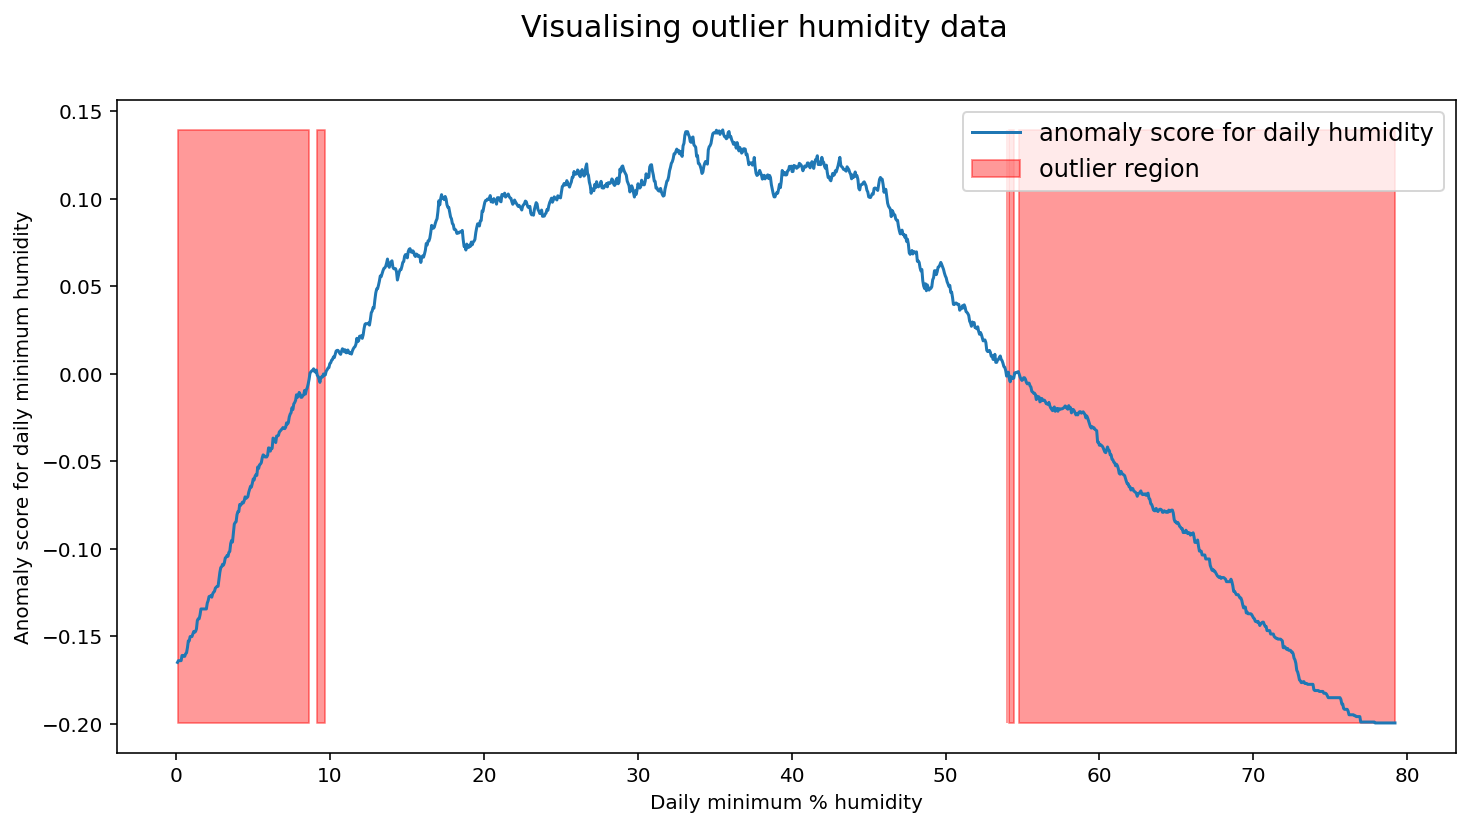

In [56]:
# Plotting the outlier region
plt.figure(figsize=(12,6))
plt.plot(min_humidity , anomaly_score_minhumidity, label="anomaly score for daily humidity")
plt.fill_between(
    min_humidity.T[0],
    np.min(anomaly_score_minhumidity),
    np.max(anomaly_score_minhumidity),
    where=outlier_minhumidity == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=12)
plt.ylabel("Anomaly score for daily minimum humidity", fontsize=10)
plt.xlabel("Daily minimum % humidity", fontsize=10)

plt.suptitle("Visualising outlier humidity data", fontsize=15)
plt.show()

The main points of interest are low humidity for fire and high humidity for hail. Looking at the anomaly plot above we can see that humidity below 10% and that above 55% is flagged as anomalies. Fire favorable conditions require the humidity to be lower than 30%, paired with the high temperatures this makes Hoedspruit a high fire risk. Although the high humidity days are not very frequent this still poses a hail risk.

In [57]:
weather['Min humidity scores']= isolation_forest.decision_function(weather[["RHum % Min"]])
weather['Min humidity anomaly']= isolation_forest.predict(weather[["RHum % Min"]])

In [58]:
min_humidity_anomaly=weather.loc[weather['Min humidity anomaly']==-1]
min_humidity_anomaly_index=list(min_humidity_anomaly.index)
min_humidity_anomaly.drop(['Rain scores','Rain anomaly','Max Temp scores',
                       'Max Temp anomaly','Min Temp scores','Min Temp anomaly'],axis = 1, inplace = True)

In [59]:
min_humidity_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
0         12.72        20.00        54.9        83.4      0.0  11.858235   
1         12.51        16.20        77.8        94.5      0.0   2.756666   
2         14.46        23.36        62.7        95.7      0.3   3.948333   
10        12.46        18.68        58.9        76.5      0.0  15.745000   
16        14.02        21.15        73.2        89.0      0.0   9.280833   

    Sun Hours  Day  Month  Year  Min humidity scores  Min humidity anomaly  
0         1.0    8      8  2018            -0.002965                    -1  
1         0.0    9      8  2018            -0.199025                    -1  
2         0.0   10      8  2018            -0.066887                    -1  
10        0.0   18      8  2018            -0.022118                    -1  
16        0.0   24      8  2018            -0.175961                    -1

In [60]:
min_humidity_anomaly["RHum % Min"].describe()

count    136.000000
mean      38.554412
std       28.109413
min        0.100000
25%        7.075000
50%       55.450000
75%       61.400000
max       79.200000
Name: RHum % Min, dtype: float64

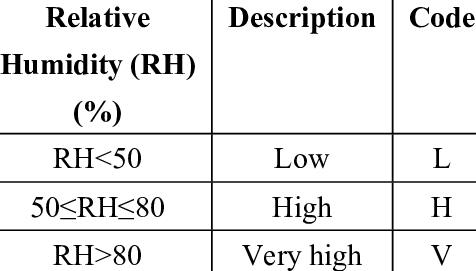

In [61]:
display.Image("Relative humidity.png")

#### Maximum relative humidity

In [62]:
isolation_forest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)

isolation_forest.fit(weather['RHum % Max'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, random_state=42)

In [63]:
max_humidity = np.linspace(
    weather["RHum % Max"].min(),
    weather["RHum % Max"].max(),
    len(weather),
).reshape(-1, 1)

anomaly_score_maxhumidity = isolation_forest.decision_function(max_humidity)

outlier_maxhumidity = isolation_forest.predict(max_humidity)

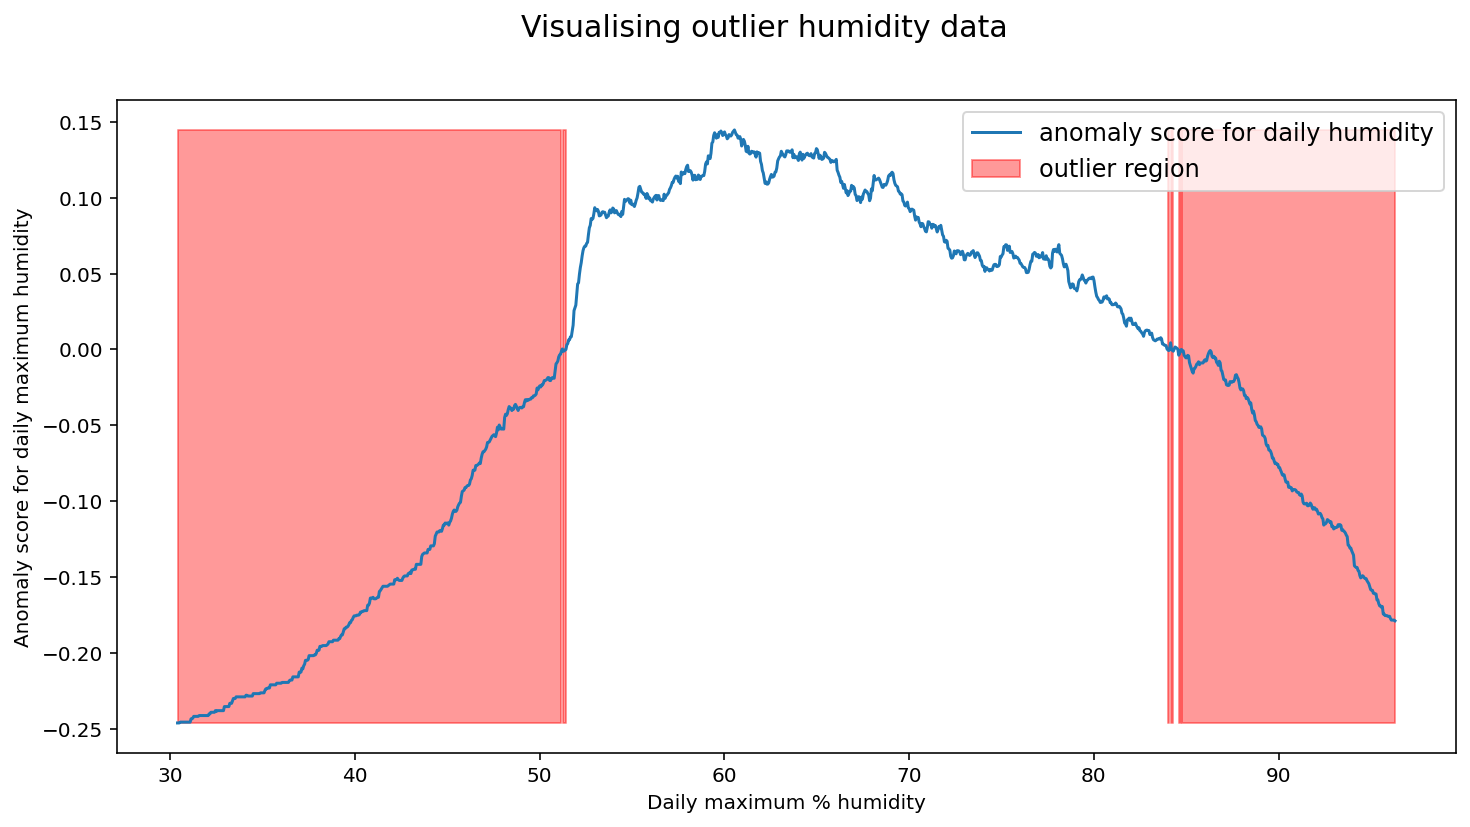

In [64]:
# Plotting the outlier region
plt.figure(figsize=(12,6))
plt.plot(max_humidity , anomaly_score_maxhumidity, label="anomaly score for daily humidity")
plt.fill_between(
    max_humidity.T[0],
    np.min(anomaly_score_maxhumidity),
    np.max(anomaly_score_maxhumidity),
    where=outlier_maxhumidity == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=12)
plt.ylabel("Anomaly score for daily maximum humidity", fontsize=10)
plt.xlabel("Daily maximum % humidity", fontsize=10)

plt.suptitle("Visualising outlier humidity data", fontsize=15)
plt.show()

In [65]:
weather['Max humidity scores']= isolation_forest.decision_function(weather[["RHum % Max"]])
weather['Max humidity anomaly']= isolation_forest.predict(weather[["RHum % Max"]])

In [66]:
maxhumidity_anomaly=weather.loc[weather['Max humidity anomaly']==-1]
maxhumidity_anomaly_index=list(maxhumidity_anomaly.index)
maxhumidity_anomaly.drop(['Rain scores','Rain anomaly','Max Temp scores','Max Temp anomaly',
                          'Min Temp scores','Min Temp anomaly','Min humidity scores','Min humidity anomaly'],
                         axis = 1, inplace = True)

In [67]:
maxhumidity_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
1         12.51        16.20        77.8        94.5      0.0   2.756666   
2         14.46        23.36        62.7        95.7      0.3   3.948333   
12        11.36        33.55        20.3        91.7      0.0   3.752916   
14        14.16        27.82        40.2        88.6      0.0   4.501666   
16        14.02        21.15        73.2        89.0      0.0   9.280833   

    Sun Hours  Day  Month  Year  Max humidity scores  Max humidity anomaly  
1         0.0    9      8  2018            -0.150197                    -1  
2         0.0   10      8  2018            -0.174527                    -1  
12        0.0   20      8  2018            -0.101759                    -1  
14        0.0   22      8  2018            -0.040300                    -1  
16        0.0   24      8  2018            -0.050993                    -1

In [68]:
maxhumidity_anomaly["RHum % Max"].describe()

count    135.000000
mean      72.580741
std       21.490572
min       30.400000
25%       48.250000
50%       85.900000
75%       88.950000
max       96.300000
Name: RHum % Max, dtype: float64

#### Daily sun hours

In [69]:
isolation_forest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)

isolation_forest.fit(weather['Sun Hours'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, random_state=42)

In [70]:
sun_hours = np.linspace(
    weather['Sun Hours'].min(),
    weather['Sun Hours'].max(),
    len(weather),
).reshape(-1, 1)

anomaly_score_sun_hours = isolation_forest.decision_function(sun_hours)

outlier_sun_hours = isolation_forest.predict(sun_hours)

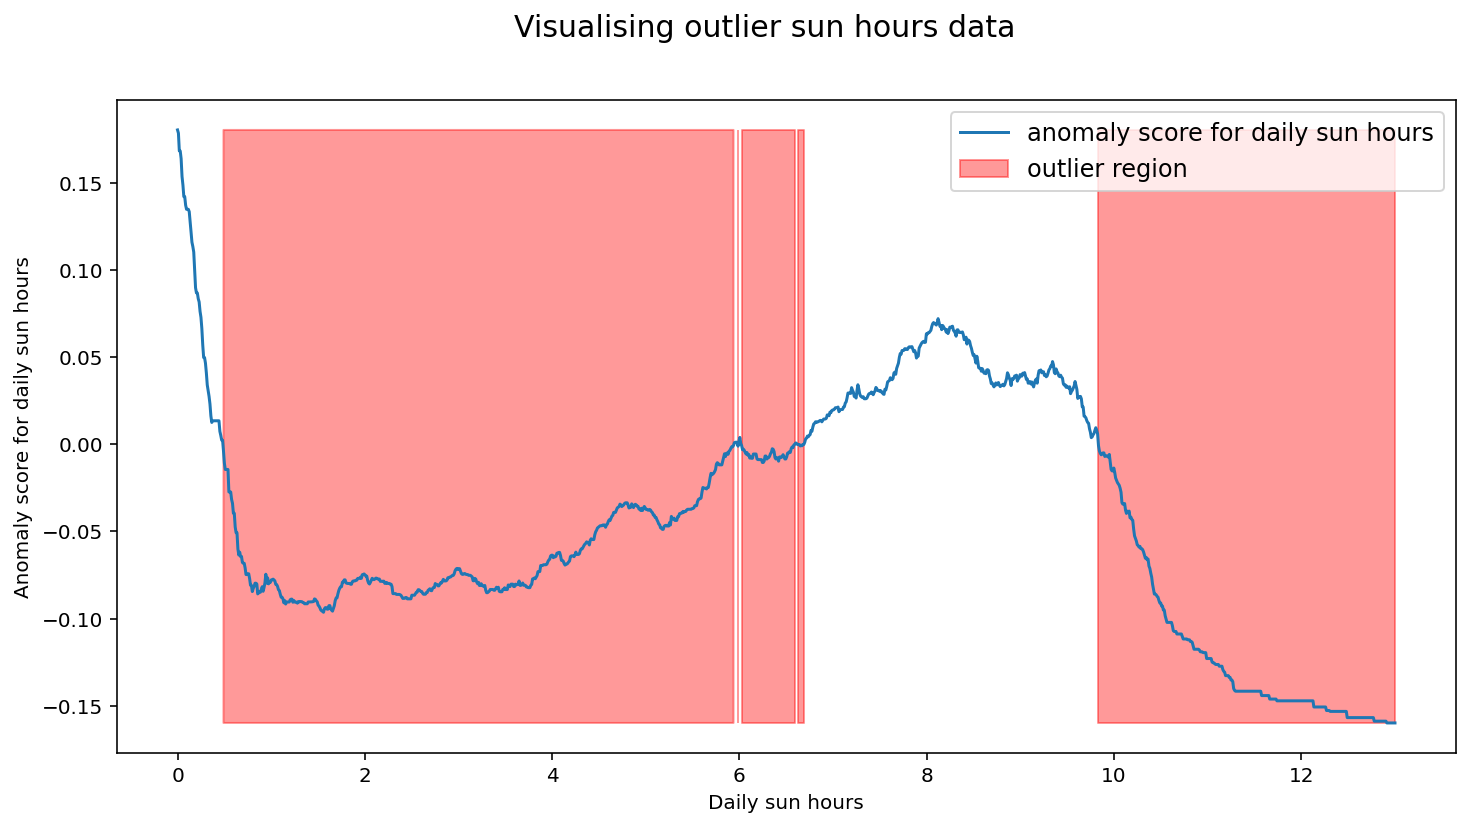

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(sun_hours , anomaly_score_sun_hours, label="anomaly score for daily sun hours")
plt.fill_between(
    sun_hours.T[0],
    np.min(anomaly_score_sun_hours),
    np.max(anomaly_score_sun_hours),
    where=outlier_sun_hours == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=12)
plt.ylabel("Anomaly score for daily sun hours", fontsize=10)
plt.xlabel("Daily sun hours", fontsize=10)

plt.suptitle("Visualising outlier sun hours data", fontsize=15)
plt.show()

In [72]:
weather['Sun hours scores']= isolation_forest.decision_function(weather[['Sun Hours']])
weather['Sun hours anomaly']= isolation_forest.predict(weather[['Sun Hours']])

In [73]:
sunhours_anomaly=weather.loc[weather['Sun hours anomaly']==-1]
sunhours_anomaly_index=list(sunhours_anomaly.index)
sunhours_anomaly.drop(['Rain scores','Rain anomaly','Max Temp scores','Max Temp anomaly','Min Temp scores','Min Temp anomaly',
                       'Min humidity scores','Min humidity anomaly','Max humidity scores','Max humidity anomaly'],
                      axis = 1, inplace = True)

In [74]:
sunhours_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
0          12.72        20.00        54.9        83.4      0.0  11.858235   
318        10.09        27.60        25.0        83.0      0.0   4.606250   
322        12.19        20.32        50.2        73.1      0.0   3.127083   
331         6.43        29.49         6.3        55.3      0.0   7.918750   
335         8.12        26.73        29.3        84.0      0.0   2.379583   

     Sun Hours  Day  Month  Year  Sun hours scores  Sun hours anomaly  
0          1.0    8      8  2018         -0.077821                 -1  
318        1.0   22      6  2019         -0.077821                 -1  
322        1.0   26      6  2019         -0.077821                 -1  
331        1.0    5      7  2019         -0.077821                 -1  
335        2.0    9      7  2019         -0.074377                 -1

In [75]:
sunhours_anomaly['Sun Hours'].describe()

count    136.000000
mean       5.293015
std        3.401122
min        0.600000
25%        2.000000
50%        4.870000
75%        9.850000
max       13.000000
Name: Sun Hours, dtype: float64

Like rain; the sun hours data has a lot of zeros and it is practically impossible unless there is a solar eclipse or full dense cloud coverage for an area to not have any sun hours recorded, the next step will therefore be removing the zero data points from the sun hours data to properly visualize the anomalies.

#### Sun hours- excluding days where there is zero sun hours

In [76]:
columns = ['Sun Hours']
weather_copy2 = weather.copy()
no_zero_sunhours_weather = weather_copy2.replace(0, pd.np.nan).dropna(axis=0, how='any', subset=columns).fillna(0)
no_zero_sunhours_weather.drop(['Rain scores','Rain anomaly','Max Temp scores','Max Temp anomaly','Min Temp scores',
                               'Min Temp anomaly','Min humidity scores','Min humidity anomaly','Max humidity scores',
                               'Max humidity anomaly','Sun hours scores','Sun hours anomaly'],axis = 1, inplace = True)

In [77]:
no_zero_sunhours_weather.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
0          12.72        20.00        54.9        83.4      0.0  11.858235   
318        10.09        27.60        25.0        83.0      0.0   4.606250   
322        12.19        20.32        50.2        73.1      0.0   3.127083   
331         6.43        29.49         6.3        55.3      0.0   7.918750   
335         8.12        26.73        29.3        84.0      0.0   2.379583   

     Sun Hours  Day  Month  Year  
0          1.0    8      8  2018  
318        1.0   22      6  2019  
322        1.0   26      6  2019  
331        1.0    5      7  2019  
335        2.0    9      7  2019

In [78]:
print("Skewness: %f" % no_zero_sunhours_weather['Sun Hours'].skew())
print("Kurtosis: %f" % no_zero_sunhours_weather['Sun Hours'].kurt())
print("\nThe skewness and the curtosis of the data decreases when the zero data points are removed",
      "\nthis means that the zeros were skewing the data")
print("\nno_zero_sunhours_weather DataFrame shape: ",no_zero_sunhours_weather.shape)

Skewness: -0.964555
Kurtosis: 0.019890

The skewness and the curtosis of the data decreases when the zero data points are removed 
this means that the zeros were skewing the data

no_zero_sunhours_weather DataFrame shape:  (356, 10)


In [79]:
isolation_forest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)

isolation_forest.fit(no_zero_sunhours_weather['Sun Hours'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, random_state=42)

In [80]:
sunhours2 = np.linspace(
    no_zero_sunhours_weather['Sun Hours'].min(),
    no_zero_sunhours_weather['Sun Hours'].max(),
    len(no_zero_sunhours_weather),
).reshape(-1, 1)

anomaly_score_sunhours2 = isolation_forest.decision_function(sunhours2)

outlier_sunhours2 = isolation_forest.predict(sunhours2)

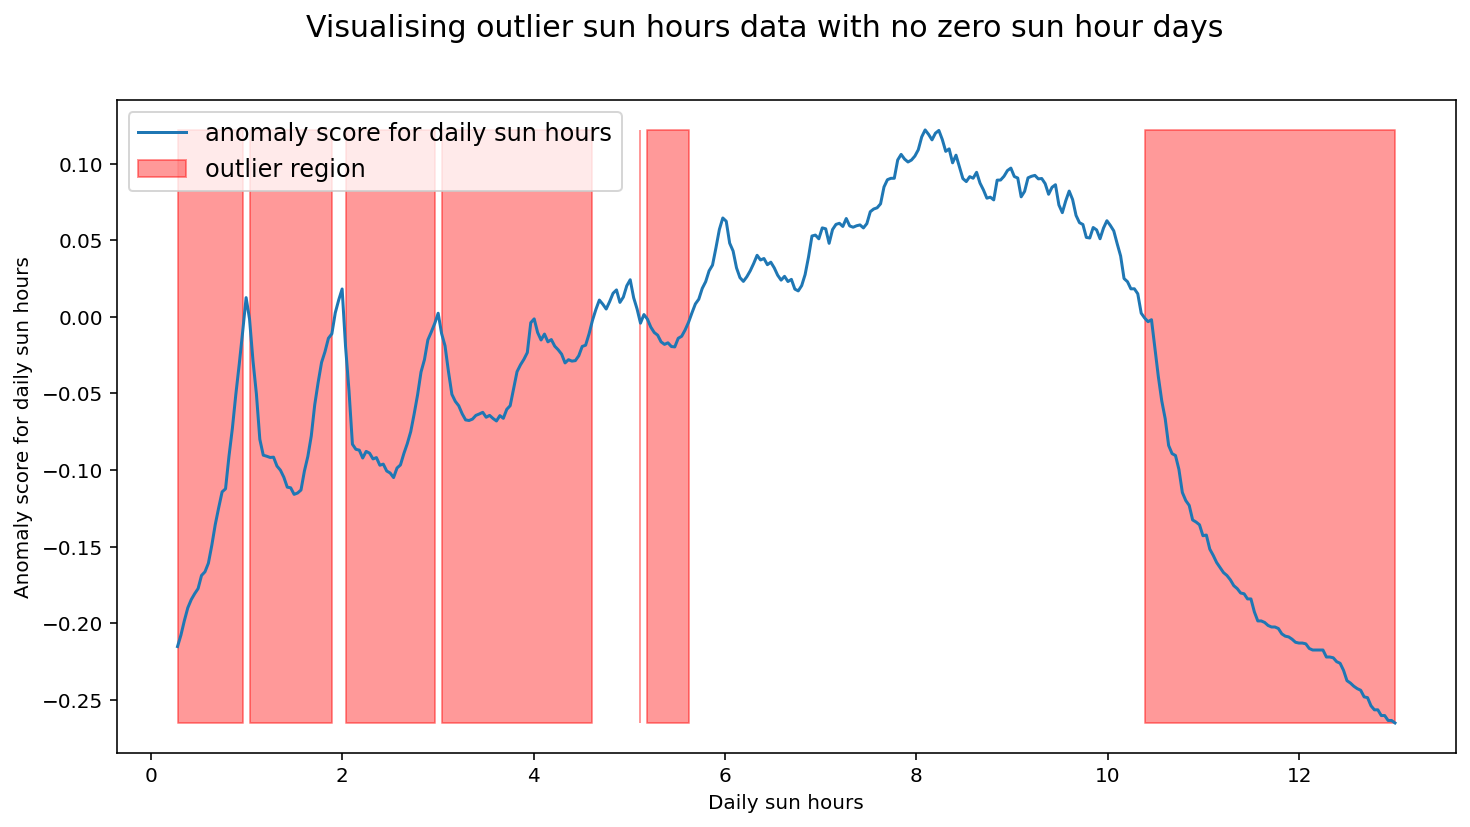

In [81]:
# Plotting the outlier region
plt.figure(figsize=(12, 6))
plt.plot(sunhours2 , anomaly_score_sunhours2, label="anomaly score for daily sun hours")
plt.fill_between(
    sunhours2.T[0],
    np.min(anomaly_score_sunhours2),
    np.max(anomaly_score_sunhours2),
    where=outlier_sunhours2 == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=12)
plt.ylabel("Anomaly score for daily sun hours", fontsize=10)
plt.xlabel("Daily sun hours", fontsize=10)

plt.suptitle("Visualising outlier sun hours data with no zero sun hour days", fontsize=15)
plt.show()

In [82]:
no_zero_sunhours_weather['Sun Hours score no_Zero']= isolation_forest.decision_function(no_zero_sunhours_weather[['Sun Hours']])
no_zero_sunhours_weather['Sun Hours anomaly no_Zero']= isolation_forest.predict(no_zero_sunhours_weather[['Sun Hours']])
no_zero_sunhours_anomaly=no_zero_sunhours_weather.loc[no_zero_sunhours_weather['Sun Hours anomaly no_Zero']==-1]
no_zero_sunhours_anomaly_index=list(no_zero_sunhours_weather.index)

In [83]:
no_zero_sunhours_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
1072         7.96        17.85        45.9        58.4      0.0   4.483333   
1073         6.08        17.54        46.9        58.3      0.0   2.426250   
1098         9.60        18.50        44.8        54.5      0.0  10.910000   
1102         8.85        18.21        41.6        59.1      0.0  10.692500   
1103         7.96        18.90        45.9        70.0      0.0   2.638750   

      Sun Hours  Day  Month  Year  Sun Hours score no_Zero  \
1072       0.80   15      7  2021                -0.110751   
1073       1.49   16      7  2021                -0.112671   
1098       3.68   10      8  2021                -0.067604   
1102       4.30   14      8  2021                -0.026255   
1103       5.52   15      8  2021                -0.014444   

      Sun Hours anomaly no_Zero  
1072                         -1  
1073                         -1  
1098                         -1  
1102                         -1  
1103                         -1

In [84]:
no_zero_sunhours_anomaly['Sun Hours'].describe()

count    36.000000
mean      5.491111
std       3.871381
min       0.280000
25%       2.657500
50%       4.275000
75%      10.427500
max      13.000000
Name: Sun Hours, dtype: float64

#### Wind speed

In [85]:
isolation_forest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)

isolation_forest.fit(weather['WSpd km/h'].values.reshape(-1, 1))

IsolationForest(contamination=0.1, random_state=42)

In [86]:
windspeed = np.linspace(
    weather['WSpd km/h'].min(),
    weather['WSpd km/h'].max(),
    len(weather),
).reshape(-1, 1)

anomaly_windspeed = isolation_forest.decision_function(windspeed)

outlier_windspeed = isolation_forest.predict(windspeed)

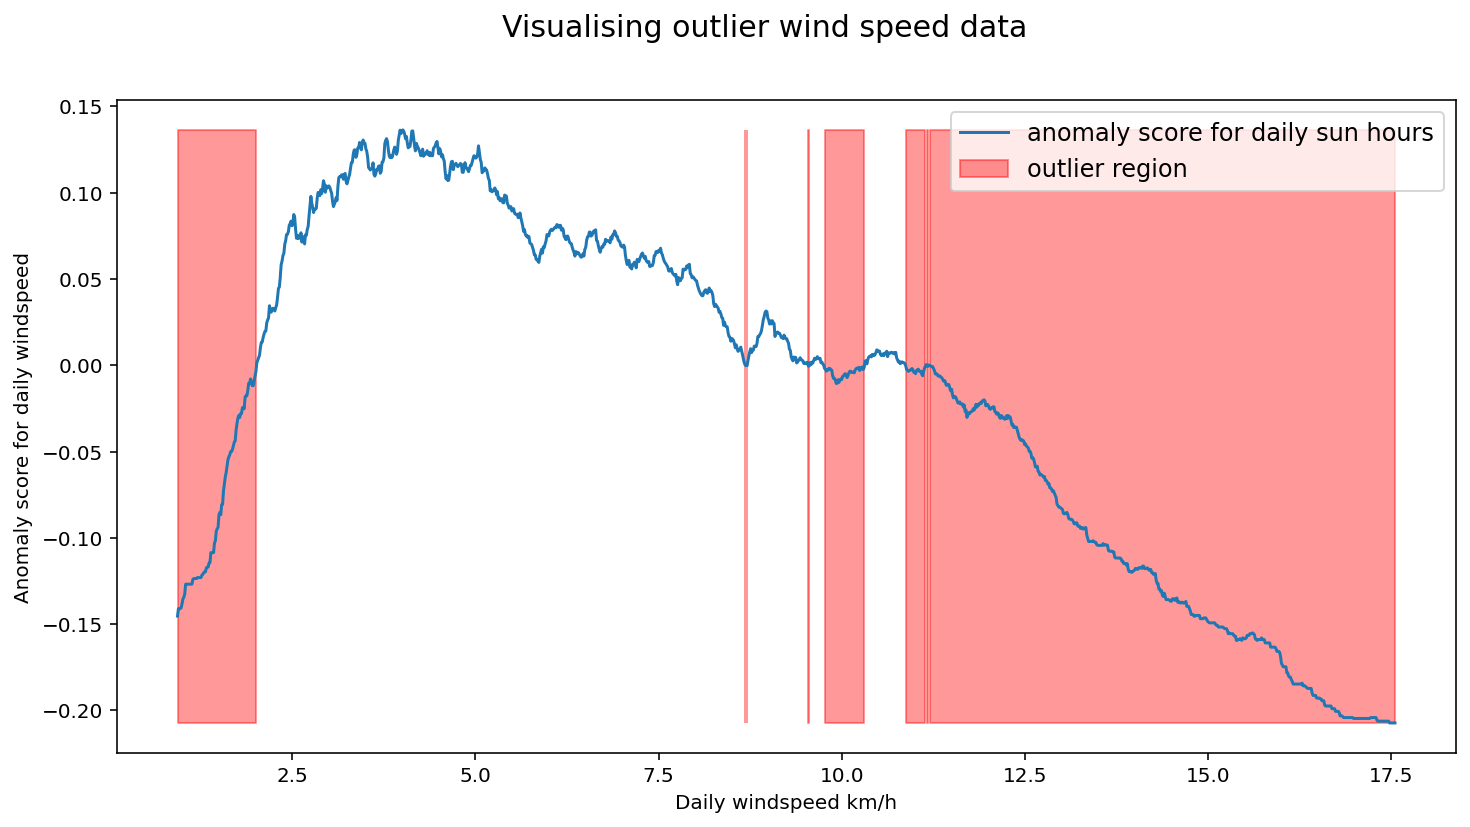

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(windspeed , anomaly_windspeed, label="anomaly score for daily sun hours")
plt.fill_between(
    windspeed.T[0],
    np.min(anomaly_windspeed),
    np.max(anomaly_windspeed),
    where=outlier_windspeed == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=12)
plt.ylabel("Anomaly score for daily windspeed", fontsize=10)
plt.xlabel('Daily windspeed km/h', fontsize=10)

plt.suptitle("Visualising outlier wind speed data", fontsize=15)
plt.show()

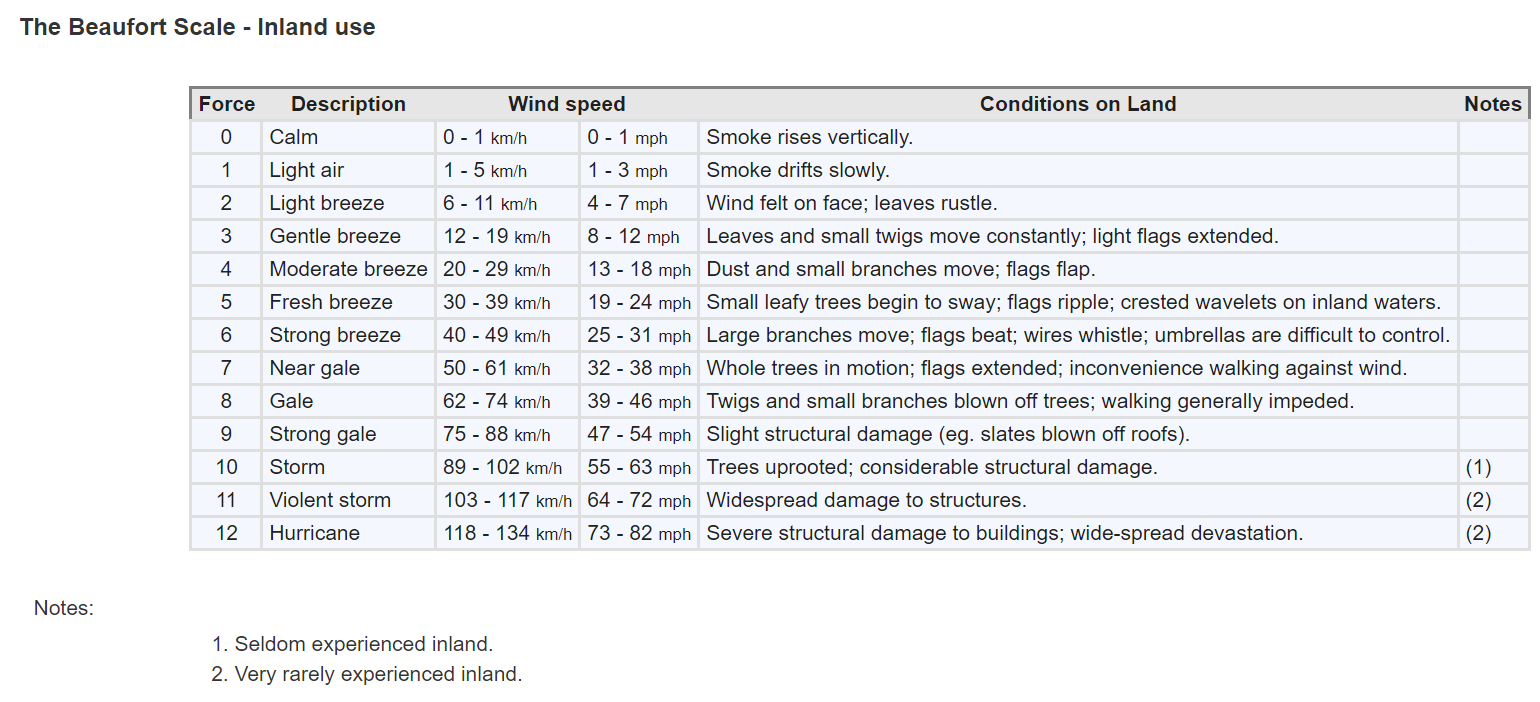

In [88]:
from IPython import display
display.Image("Beufort windspeed.png")

Looking at the above Beufort scale for inland wind we can see that Bavaria is not so windy, typically the average windspeed in a windy region goes above 40 km/h. The wind in Bavaria only goes up to 17.5 km/h.

In [89]:
weather['Windspeed scores']= isolation_forest.decision_function(weather[['WSpd km/h']])
weather['Windspeed anomaly']= isolation_forest.predict(weather[['WSpd km/h']])

In [90]:
windspeed_anomaly=weather.loc[weather['Windspeed anomaly']==-1]
windspeed_anomaly_index=list(windspeed_anomaly.index)
windspeed_anomaly.drop(['Rain scores','Rain anomaly','Max Temp scores','Max Temp anomaly','Min Temp scores','Min Temp anomaly',
                        'Min humidity scores','Min humidity anomaly','Max humidity scores','Max humidity anomaly',
                        'Sun hours scores','Sun hours anomaly'],axis = 1, inplace = True)

In [91]:
windspeed_anomaly.head()

Min TWet °C  Max TDry °C  RHum % Min  RHum % Max  Rain mm  WSpd km/h  \
0         12.72        20.00        54.9        83.4      0.0  11.858235   
10        12.46        18.68        58.9        76.5      0.0  15.745000   
43        13.95        27.43        30.0        74.3      0.0  15.700416   
52        14.94        29.13        29.8        79.8      0.0  16.254583   
56         8.77        26.83        20.5        75.2      0.0  14.695416   

    Sun Hours  Day  Month  Year  Windspeed scores  Windspeed anomaly  
0         1.0    8      8  2018         -0.022862                 -1  
10        0.0   18      8  2018         -0.158982                 -1  
43        0.0   20      9  2018         -0.158982                 -1  
52        0.0   29      9  2018         -0.184774                 -1  
56        0.0    3     10  2018         -0.136911                 -1

In [92]:
windspeed_anomaly['WSpd km/h'].describe()

count    136.000000
mean       9.639564
std        4.993593
min        0.932500
25%        1.957917
50%       11.411458
75%       12.635625
max       17.554583
Name: WSpd km/h, dtype: float64

#### Isolation Forrest Schematic

In [93]:
from scipy import stats
from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [94]:
# Data pre-processing
cols = ['Rain mm', 'Max TDry °C']
minmax = MinMaxScaler(feature_range=(0, 1))
original_weather[cols] = minmax.fit_transform(original_weather[cols])
original_weather[cols].head()

Rain mm  Max TDry °C
0  0.000000     0.150521
1  0.000000     0.003860
2  0.004196     0.280201
3  0.000000     0.351988
4  0.000000     0.360479

In [95]:
X1 = original_weather['Max TDry °C'].values.reshape(-1,1)
X2 = original_weather['Rain mm'].values.reshape(-1,1)

X = np.concatenate((X1,X2), axis = 1)

In [96]:
outliers_fraction = 0.04

# Picking 4 outlier detection models here. You can include others
classifiers = {"Isolation Forest": IForest(contamination=outliers_fraction, random_state=42, behaviour="new")}

OUTLIERS: 55 | INLIERS: 1297 | MODEL: Isolation Forest


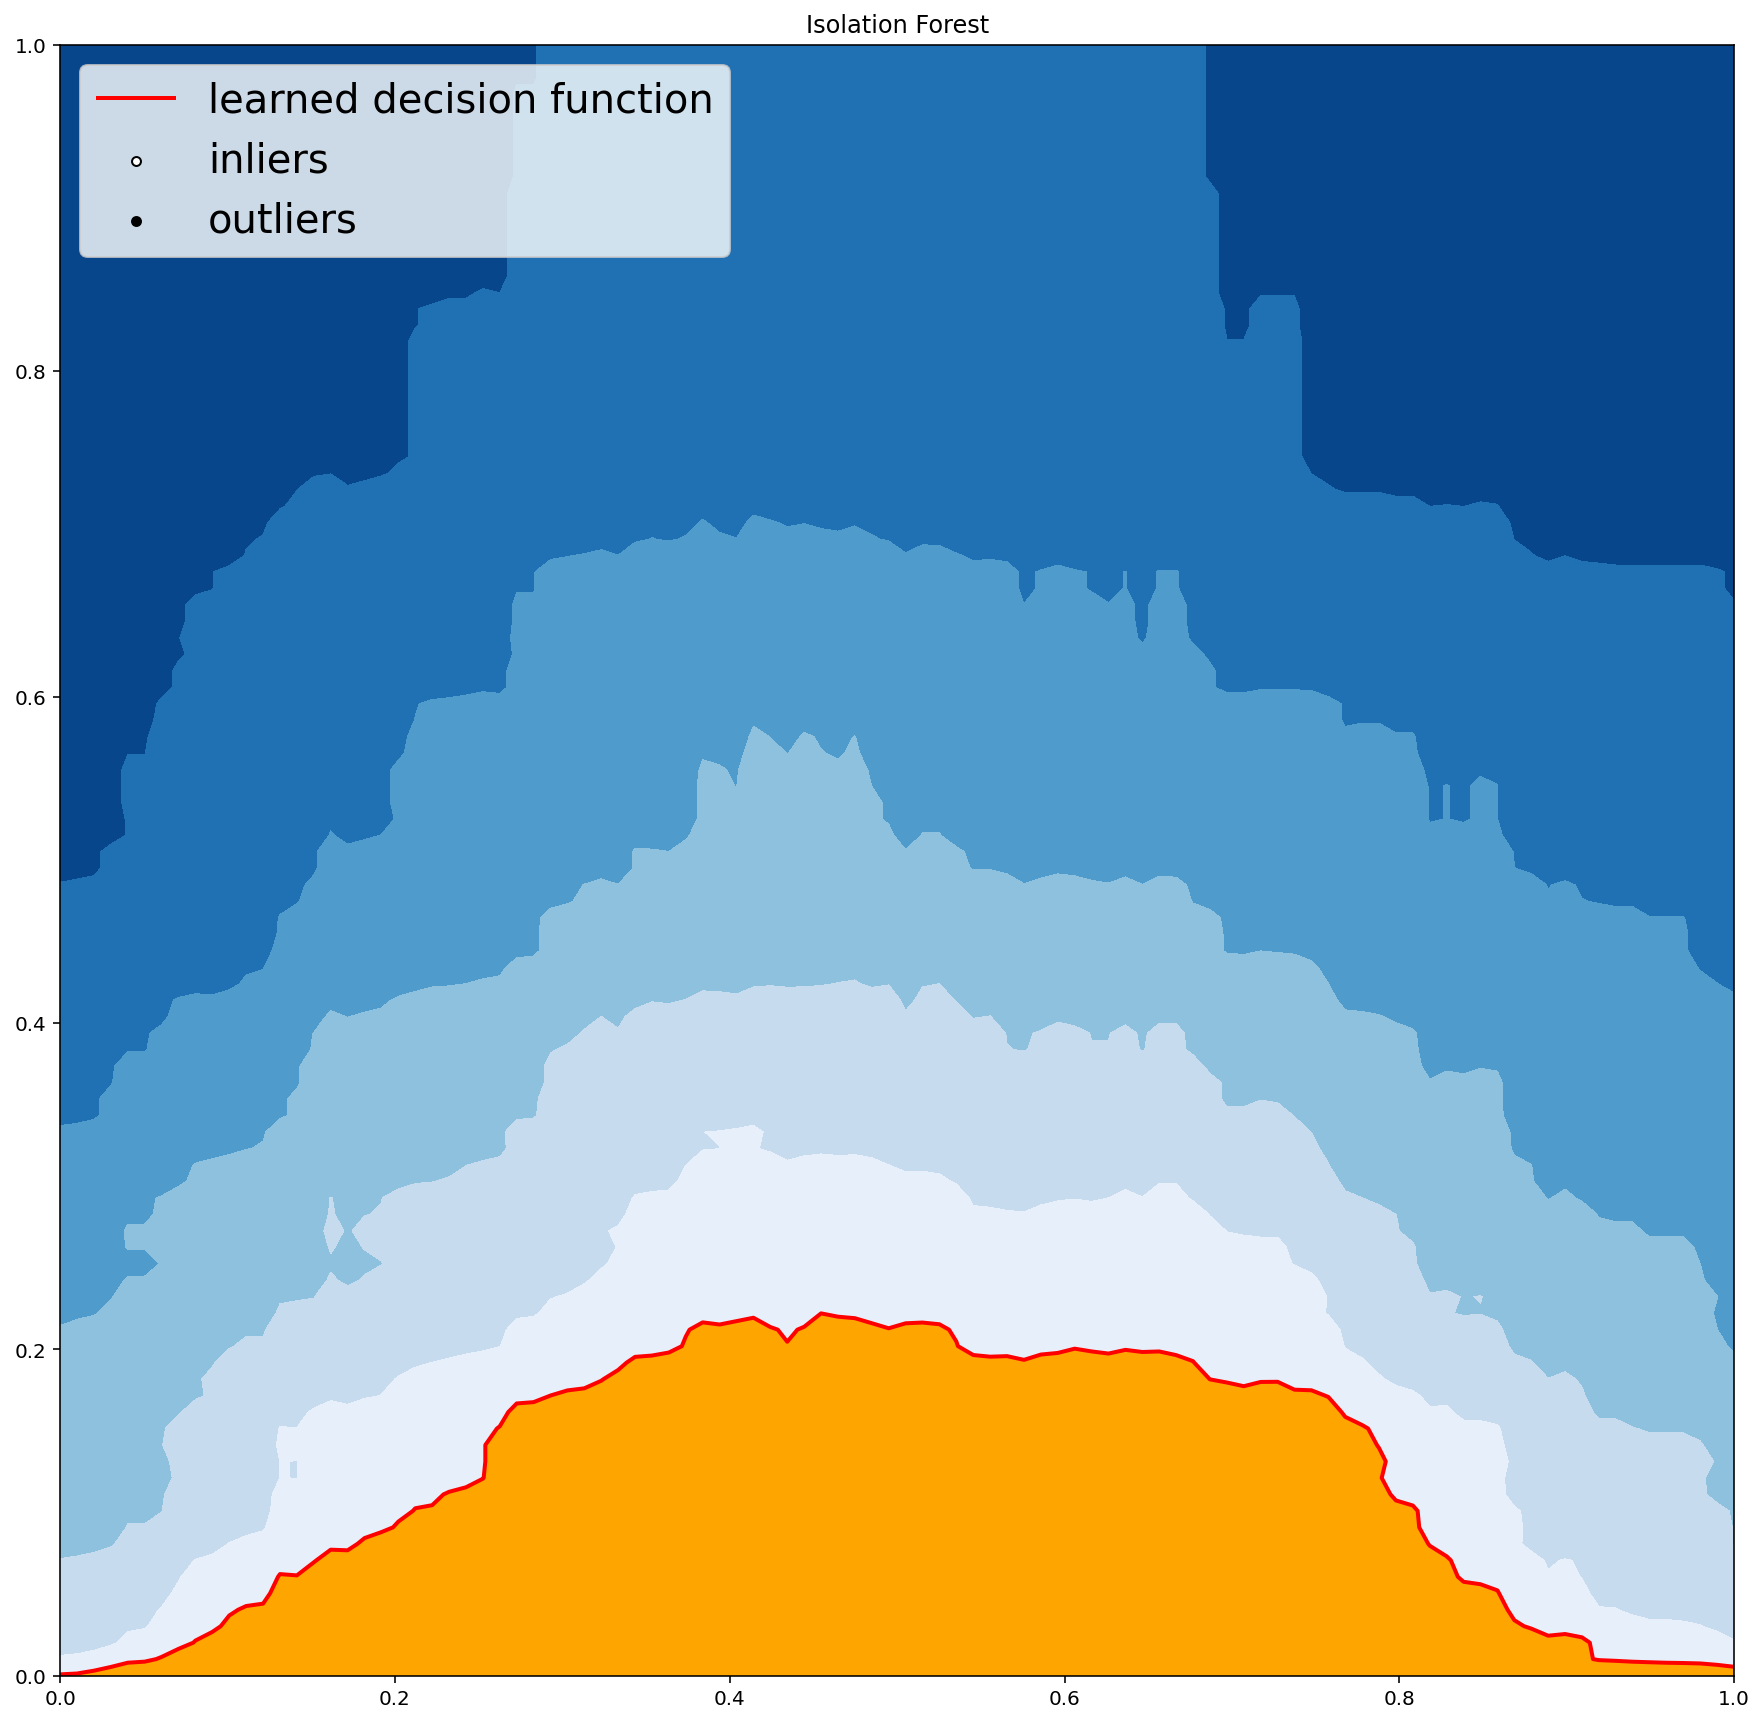

In [97]:
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
outliers = []

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(15, 15))
    
    # copy of dataframe
    df = weather.copy()
    df['outlier'] = y_pred.tolist()
    
    # creating a combined dataframe of outliers from the 4 models
    outliers.append(df.loc[df['outlier'] == 1])
    outliers_df = pd.concat(outliers) 
    
    # IN1 - inlier feature 1,  IN2 - inlier feature 2
    IN1 =  np.array(df['Max TDry °C'][df['outlier'] == 0]).reshape(-1,1)
    IN2 =  np.array(df['Rain mm'][df['outlier'] == 0]).reshape(-1,1)
     
    
    # OUT1 - outlier feature 1, OUT2 - outlier feature 2
    OUT1 =  df['Max TDry °C'][df['outlier'] == 1].values.reshape(-1,1)
    OUT2 =  df['Rain mm'][df['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS:',n_outliers, '|', 'INLIERS:',n_inliers, '|', 'MODEL:',clf_name)
     # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
           
    b = plt.scatter(IN1,IN2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OUT1,OUT2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=mpl.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

### 5. Weighted outlier anomaly score

Since the contamination factor of all the isolation forest computations was kept constant at 0.1, the outcome outliers can be used to see which peril bears the most risk in Hoedspruit area.

In [98]:
score_df = pd.DataFrame()
score_df['Rain mm'] = rain_anomaly['Rain scores'] 
score_df['RHum % Min'] = min_humidity_anomaly["Min humidity scores"] 
score_df['RHum % Max'] = maxhumidity_anomaly["Max humidity scores"] 
score_df['Min TWet °C'] = min_temp_anomaly["Min Temp scores"] 
score_df['Max TDry °C'] = max_temp_anomaly["Max Temp scores"] 
score_df['WSpd km/h'] = windspeed_anomaly['Windspeed scores'] 
score_df['Sun Hours'] = sunhours_anomaly['Sun hours scores'] 

In [99]:
a = (abs(score_df.mean()).to_list())
b = (abs(score_df.mean()*100).to_list())

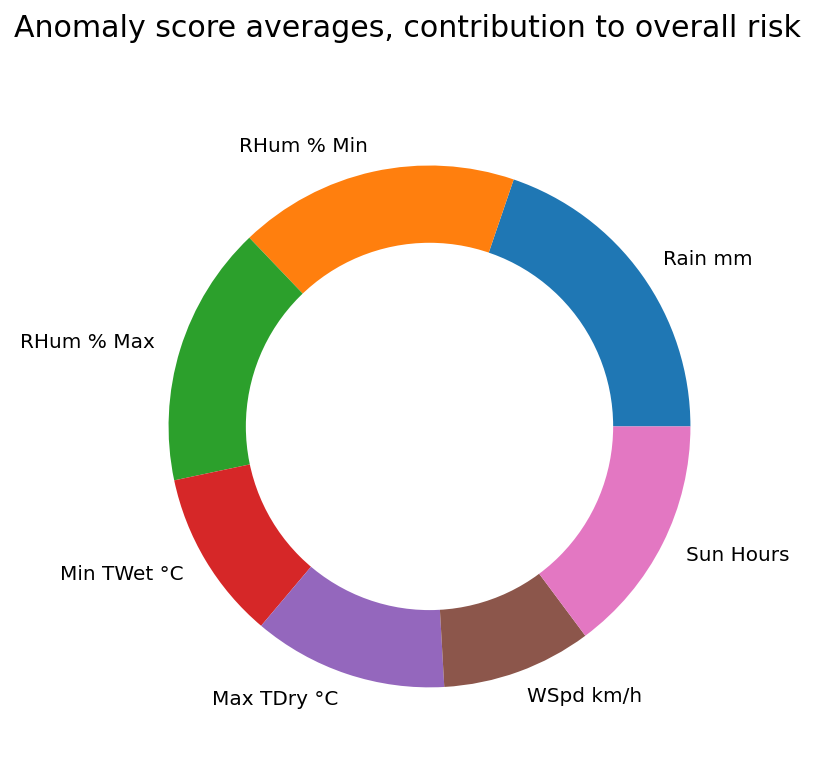

In [100]:
plt.figure(figsize=(12, 6))
plt.pie(b, labels = ['Rain mm', 'RHum % Min','RHum % Max', 'Min TWet °C', 'Max TDry °C', 'WSpd km/h', 'Sun Hours'])
circle = plt.Circle( (0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(circle)
plt.suptitle("Anomaly score averages, contribution to overall risk", fontsize=15)
plt.show()

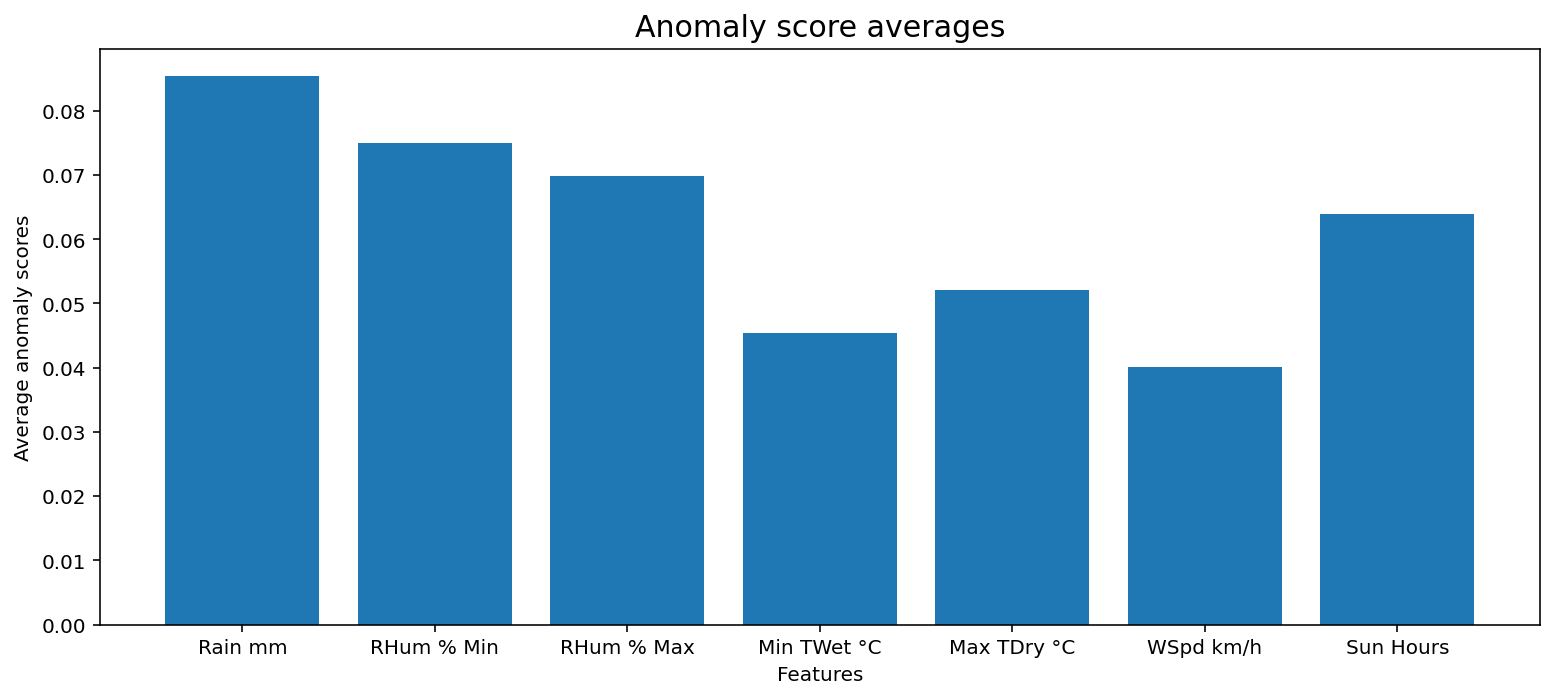

In [101]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0,0,1,1])
titles = ['Rain mm', 'RHum % Min','RHum % Max', 'Min TWet °C', 'Max TDry °C', 'WSpd km/h', 'Sun Hours']
ax.bar(titles,a)
ax.set_xlabel('Features')
ax.set_ylabel('Average anomaly scores')
ax.set_title('Anomaly score averages',fontsize=15)
plt.show()

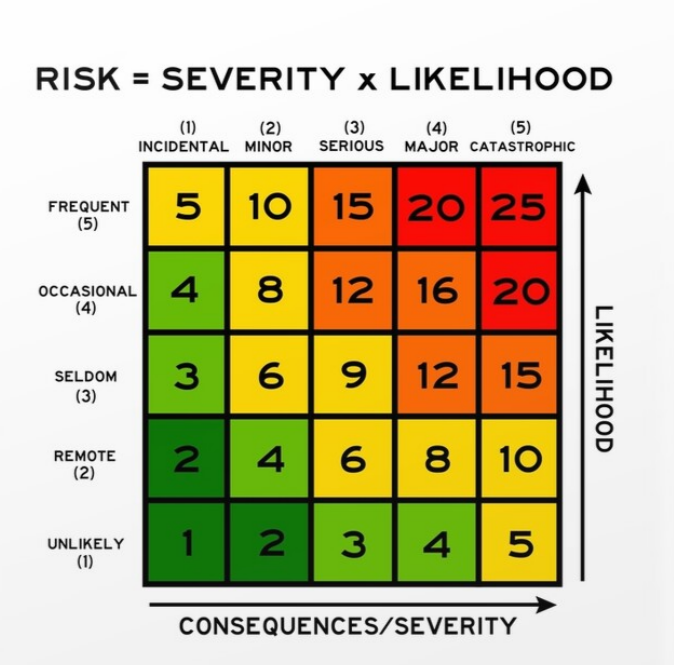

In [102]:
display.Image("risk_matrix_crop.png")

#### Filtering the outlier extremes

Focusing on the outer extremes that contribute to perils; the above matrix, the research based classifications and oulier identification will be used to obtain one value that gives an indication of the severity and frequency weather events that pose potential insurance risks.

The severity score is obtained by taking an average of the extreme values and dividing it by the highest possible value, then multiplying by 5. The same will be done for the frequency calculations.

##### Hail events

In [103]:
#Rainfall
heavy_rain = no_zero_rain_anomaly.loc[no_zero_rain_anomaly['Rain mm']>60]
mean_heavy_rain = heavy_rain['Rain mm'].mean()
heavy_rain_factor = round((mean_heavy_rain/124.24)*5,2)

#High humidity
high_humidity = maxhumidity_anomaly.loc[maxhumidity_anomaly['RHum % Max']>80]
mean_high_humidity = high_humidity['RHum % Max'].mean()
high_humidity_factor = round((mean_high_humidity/100)*5,2)

print('Heavy rain secerity factor =', heavy_rain_factor,
      '\nHigh humidity severity factor =', high_humidity_factor)

Heavy rain secerity factor = 2.88 
High humidity severity factor = 4.45


The low temperature in the data does not reach hail risk low temperatures, for there to be hail the temperature has to go below zero and the data does not reflect that. The temperature at cloud level is not the same as the one recorded in this data. For the sake of this exercise the temp risk score will be considered to be moderate at 50% (that is a score of 2.5).

The wind speed also falls below the minimum required for hail which is 35-55 km/h, the highest wind speed is 17.5 km/h. However, there is no data for wind gusts which are the causes of high speed winds. The wind speed also affects the fire but that is also still the high wind speed which is higher than the data's maximum. For the purpose of obtaining the index the severity score will be set at 2.5 as well. For the frequency score however, an assumption that windspeed above 15 km/h is due to gust is made in order to estimate the gust frequency.

In [104]:
#Overall hail severity factor
hail_severity_data = [heavy_rain_factor, high_humidity_factor, 2.5, 2.5] 
hail_severity_factor = round((sum(hail_severity_data)/20),2)
print('Overall hail severity score =', hail_severity_factor)

Overall hail severity score = 0.62


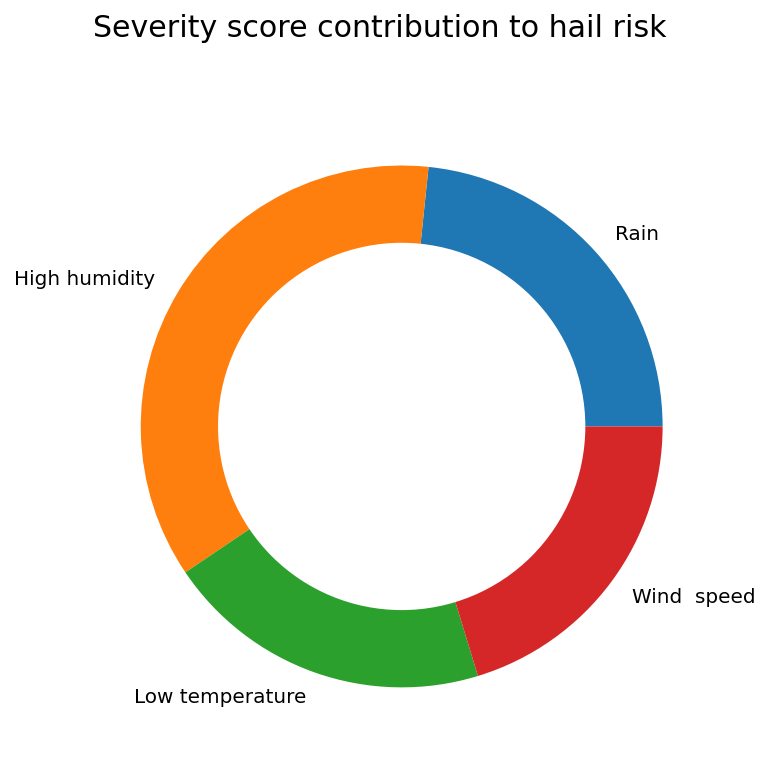

In [105]:
plt.figure(figsize=(12, 6))
plt.pie(hail_severity_data, labels = ['Rain', 'High humidity', 'Low temperature', 'Wind  speed'])
circle = plt.Circle( (0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(circle)
plt.suptitle("Severity score contribution to hail risk", fontsize=15)
plt.show()

In [106]:
#heavy_rain_frequency_factor
heavy_rain_frequency = round(((heavy_rain['Rain mm'].count()/365)*5),3)

#high_humidity_frequency_factor
high_humidity_frequency = round(((high_humidity['RHum % Max'].count()/365)*5),2)

#windspeed_frequency_factor
gust_windspeed = windspeed_anomaly.loc[windspeed_anomaly['WSpd km/h']>15]
windspeed_frequency = round(((gust_windspeed['WSpd km/h'].count()/365)*5),2)

print('Heavy rain frequency factor =',heavy_rain_frequency,
      '\nHigh humidity frequency factor =', high_humidity_frequency,
     '\nHigh windspeed frequency factor = ',windspeed_frequency)

Heavy rain frequency factor = 0.014 
High humidity frequency factor = 1.15 
High windspeed frequency factor =  0.16


In [107]:
#Overall hail frequency factor
hail_frequency_data = [heavy_rain_frequency, high_humidity_frequency, 0, windspeed_frequency] 
hail_frequency_factor = round((sum(hail_frequency_data)/20),2)
print('Overall hail ferquency score =', hail_frequency_factor)

Overall hail ferquency score = 0.07


##### Fire events

In [108]:
#Low humidity
low_humidity = min_humidity_anomaly.loc[min_humidity_anomaly['RHum % Min']<30]
mean_low_humidity = low_humidity['RHum % Min'].mean()
low_humidity_severity_factor = 5-(round((mean_low_humidity/100)*5, 2))

#High temperature
high_temperature = max_temp_anomaly.loc[max_temp_anomaly['Max TDry °C']>35]
mean_high_temperature = high_temperature['Max TDry °C'].mean()
high_temperature_factor = (round((mean_high_temperature/45)*5, 2))

print('Low humidity severity factor =', low_humidity_severity_factor,
     '\nHigh temperature secerity factor = ', high_temperature_factor)

Low humidity severity factor = 4.69 
High temperature secerity factor =  4.27


In [109]:
#Overall fire severity factor
fire_data = [low_humidity_severity_factor, high_temperature_factor, 2.5]
fire_severity_factor = round((sum(fire_data)/15),2)
print('Overall fire severity score =', fire_severity_factor)

Overall fire severity score = 0.76


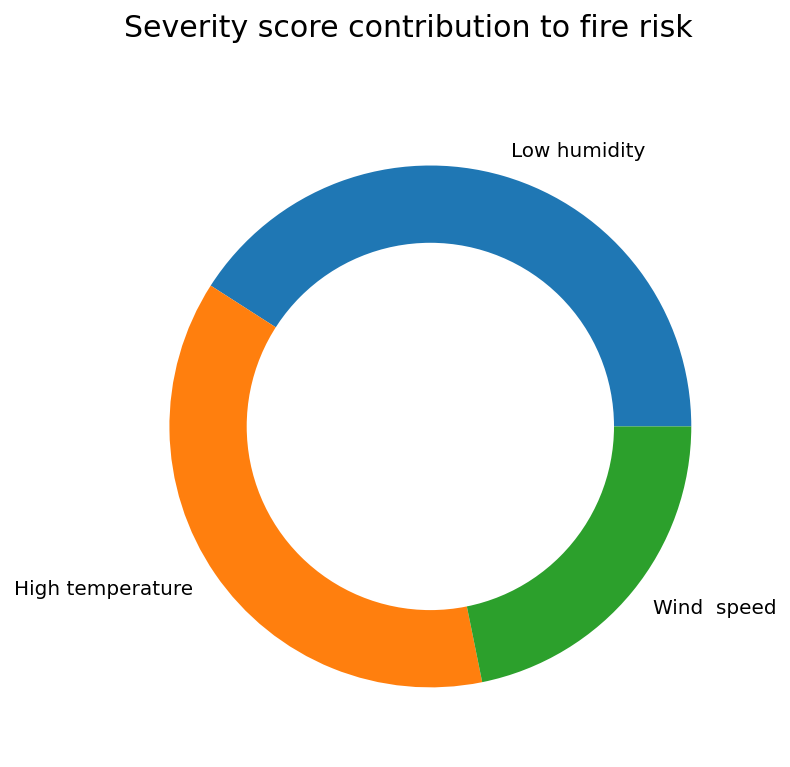

In [110]:
plt.figure(figsize=(12, 6))
plt.pie(fire_data, labels = ['Low humidity', 'High temperature', 'Wind  speed'])
circle = plt.Circle( (0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(circle)
plt.suptitle("Severity score contribution to fire risk", fontsize=15)
plt.show()

In [111]:
#Low humidity frequency factor
low_humidity_frequency = round(((low_humidity['RHum % Min'].count()/365)*5),2)

#High temerature frequency factor
high_temperature_frequency = round(((high_temperature['Max TDry °C'].count()/365)*5),2)

print('Low humidity frequency factor =', low_humidity_frequency,
     '\nHigh temperature frequency factor = ', high_temperature_frequency)

Low humidity frequency factor = 0.78 
High temperature frequency factor =  0.85


In [112]:
#Overall fire frequency factor
fire_frequency_data = [low_humidity_frequency, high_temperature_frequency, windspeed_frequency] 
fire_frequency_factor = round((sum(fire_frequency_data)/15),2)
print('Overall fire frequecy score =', fire_frequency_factor)

Overall fire frequecy score = 0.12


### 6. Overall risk calculation

Risk is calculated using risk likelihood (frequency) and severity

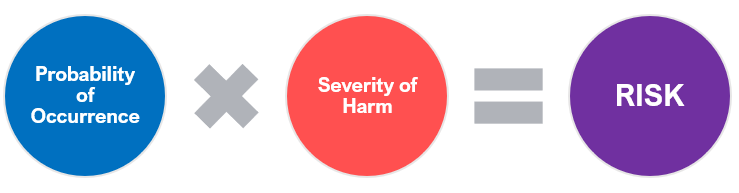

In [113]:
display.Image("risk-formula.png")

In [114]:
Hail_risk = hail_severity_factor*hail_frequency_factor*100
Fire_risk = fire_frequency_factor*fire_frequency_factor*100
print('Hoedspruit hail risk:', Hail_risk,'%', '\nHoedspruit fire risk:', Fire_risk,'%' )

Hoedspruit hail risk: 4.34 % 
Hoedspruit fire risk: 1.44 %


### 7. Results interpretation

The conditions mentioned at the begining of this notebook need to occur at the same time for these perils to happen. The data analysed above has provided some insight and can be interpreted as follows:

#### Hail
Hail forms when the cloud temperature is below zero and water droplets are supercooled, in the presence of high humidity. For the smallest hailstone to form an updraft of around 35 - 55 km/h is required. Larger stones, the size of golf balls, 40 mm diameter, require updrafts of around 90 km/h to form. Looking at the above wind speed data, it can be seen that the daily wind speed does not go up to these ranges, the updrafts usually occur in the form of wind gusts. In addition, the lowest minimum temperature in this dataset is 1.8°C, this is the atmospheric temperature, and it does not accurately predict the cloud temperature, however, negative atmospheric temperatures would serve as a good indicator of extremely cold weather that is conducive for hail formation. The data does however, meet the condition of high humidity. 

Considering the above findings, it can be seen that the conditions that are conducive for hail are barely met. This means that Hoedspruit is at low risk for hail. The event may occur, but it is on rare occasion when the perfect conditions for hail are met. The hail severity factor is above 0.5 which means that though it may not be frequent, when it does actually occur the hailstorm is likely to be severe and leave bad damage. Based on the I-leaf data Hoedspruit is at 4.34% risk of hailstorms.


#### Fire
For a veld fire to thrive, the temperature must be above 25°C and a relative humidity of less than 30%. The conditions for veld fires occurring simultaneously are highly likely, given the Hoedspruit is a fairly dry area and according to the anomaly detection above we can see that the maximum temperature does on occasion reach highs of above 35°C and humidity does go as low as 1.8%. This is very conducive to veld fires and implies that Hoedspruit is at high risk for veld fires. Looking at the fire severity factor it can be seen that there is a high probability of the fire being severe, which could lead to serious damage. The frequency of occurrence, however, is extremely low. Based on the I-leaf data Hoedspruit is at 1.44% risk of veld fires.


### 8. References

- https://www.besttimetovisit.co.za/south-africa/hoedspruit-3497598/
- https://sagrainmag.co.za/2020/09/16/top-tips-for-burning-veld
- https://southafrica.co.za/hail-south-africa.html
- https://pta-gis-2-web1.csir.co.za/portal/apps/GBCascade/index.html?appid=a726c58f435141ba80b57fe21d3ec744
- https://www.researchgate.net/figure/Rainfall-classification-based-on-daily-rainfall-of-a-station-following-nomenclature-from_tbl2_277714967
- https://www.researchgate.net/figure/Space-classification-based-on-temperature_tbl1_328370613